In [1]:
from PIL import Image, ImageDraw

def matrix(string):
    return np.array(list(map(int, string.replace('\xa0','0').split(','))))

class Nonogram:
    def __init__(self, height = 30, width = 30, step_size = 25):
        
        image = Image.new(mode='L', size=(height* step_size, width * step_size), color=255)

        # Draw some lines
        draw = ImageDraw.Draw(image)
        y_start = 0
        y_end = image.height

        for x in range(0, image.width, step_size):
            line = ((x, y_start), (x, y_end))
            draw.line(line, fill=128)

        x_start = 0
        x_end = image.width

        for y in range(0, image.height, step_size):
            line = ((x_start, y), (x_end, y))
            draw.line(line, fill=128)
        
        self.step_size = step_size
        self.imgdraw = ImageDraw.Draw(image)
        self.image = image  
        
    def color(self,i,j):        
        self.imgdraw.rectangle([(i * self.step_size, j * self.step_size),((i + 1) * self.step_size,(j + 1) *self.step_size)], fill = 0)
    

    def draw(self,i,j,text):
        i= (i + 0.4) * self.step_size
        j= (j + 0.3) * self.step_size
        self.imgdraw.text((i,j), text, fill =0)

    def matrixdraw(self,M, start = (0,0)):
        for i, m in enumerate(M):
            for j, v in enumerate(m):
                self.draw(i + start[0],j + start[1],str(v) if v != 0 else '')


class Matrix(Nonogram):
    def __init__(self,data):
        size = (data['sizeCol'],data['sizeRow'])
        c = matrix(data['colClues']).reshape(size[0],-1).T
        r = matrix(data['rowClues']).reshape(-1,size[1]).T
        super().__init__(r.shape[0] + c.shape[0],r.shape[1] + c.shape[1])
        self.matrixdraw(r, start = (c.shape[0],0))
        self.matrixdraw(c, start = (0,r.shape[1]))
        self.emptyshape = (c.shape[0],r.shape[1])
        self.c = c.T
        self.r = r
        self.shape = (c.shape[1],r.shape[0])
        self.solution = data['solution']
        self.imagecopy = self.image.copy()
        self.R = [{'len':len([c for c in r if c!=0]),
                 'sum': sum(r),
                 'entity':np.array([[c] for c in r if c!=0])} for r in self.r]
        self.C = [{'len':len([c for c in r if c!=0]),
                 'sum': sum(r),
                 'entity':np.array([[c] for c in r if c!=0])} for r in self.c]
        
    def Mdraw(self,M = None):
        if(M is None):
            M = np.zeros(self.shape)
            
        self.image = self.imagecopy.copy()
        self.imgdraw = ImageDraw.Draw(self.image)
        M = M.T
        for i, m in enumerate(M):
            for j, v in enumerate(m):
                if(v):
                    self.color(i + self.emptyshape[0],j + self.emptyshape[1])
        return self.image
                    
    def onezero2(mask):
        c,oz = np.nonzero(np.hstack([
            mask[:,:1],
            mask[:, 1:] ^ mask[:,:-1],
            mask[:,-1:]]))
        oz = np.diff(oz)
        ones = oz[::2]
        cone = c[::2]
        if(mask[-1].all() == False):
            ones = np.append(ones, 0)
            cone = np.append(cone, len(mask)-1)
        return ones,cone

    def onezero(mask):
        mask= np.pad(mask, ((0,0),(0,1)), constant_values=False)   
        c,oz = np.nonzero(mask ^ np.roll(mask,1))
        oz = np.diff(oz)
        ones = oz[::2]
        cone = c[::2]
        if(mask[-1].all() == False):
            ones = np.append(ones, 0)
            cone = np.append(cone, len(mask)-1)
        return ones,cone
    
    def heuristic(row,entity):
        ones,cone = Matrix.onezero(row)
        sums = np.bincount(cone, weights=ones)
        lens = np.bincount(cone, weights=np.ones(len(cone)))
        h = np.abs(sums - entity['sum']) + (lens - entity['len'])**2
        return h

    def advheuristic(row,entity):
        ones,cone = Matrix.onezero(row)
        sums = np.bincount(cone, weights=ones)
        lens = np.bincount(cone, weights=np.ones(len(cone)))
        h = np.abs(sums - entity['sum']) + (lens - entity['len'])**2
        zhs = np.where(h == 0)[0]
        
        if(len(zhs)):
            focus = np.isin(cone,zhs)
            focus = ones[focus].reshape(entity['len'],-1)
            zh = np.sum(np.abs(focus - entity['entity']),axis=0) 
            h[zhs] = zh / entity['sum']
            return h
        else:
            return h        
        
    def advcost(self,M):
        MT = np.transpose(M,(0,2,1))
        return np.sum(np.array([Matrix.advheuristic(r,n) for r,n in zip (np.rollaxis(M, 2),self.R)]),axis = 0) + \
               np.sum(np.array([Matrix.advheuristic(r,n) for r,n in zip (np.rollaxis(MT, 2),self.C)]),axis = 0)
    
    def cost(self,M):
        MT = np.transpose(M,(0,2,1))
        return np.sum(np.array([Matrix.heuristic(r,n) for r,n in zip (np.rollaxis(M, 2),self.R)]),axis = 0) + \
               np.sum(np.array([Matrix.heuristic(r,n) for r,n in zip (np.rollaxis(MT, 2),self.C)]),axis = 0)

In [51]:
import cProfile
import pstats
def Stats(f):
    profile = cProfile.Profile()
    profile.runcall(f)
    ps = pstats.Stats(profile)
    ps.print_stats()

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('nonogram.csv')
M = Matrix(df.iloc[2494])

In [53]:
import random
nagent = 3000
nchildren = 10000
niteration = 100
mrate = 0.05

def crossover(agents,nchildren , M = 2):
        
    Aindicies = np.random.choice(range(len(agents)),size=((nchildren+1)*M,2))
    Aindicies = Aindicies[Aindicies[:,0] != Aindicies[:,1]][:nchildren]

    if(len(Aindicies) != nchildren):
        return crossover(agents,nchildren,M=M+1)
        
    shx,shy = agents[0].shape
    K = np.random.randint(0, shx-2,size = nchildren)
    L = np.random.randint(K+1, shx,size = nchildren)
    M = np.random.randint(0, shy-2,size = nchildren)
    N = np.random.randint(M+1, shy,size = nchildren)
    
    children = agents[Aindicies]
    for index in range(len(children)):
        k,l,m,n = K[index],L[index],M[index],N[index]
        children[index][0][k:l,m:n] = children[index][1][k:l,m:n]
    return [mutate(children[:,0])]

def mutate(agent):
  Cells = np.random.rand(*agent.shape) < mrate
  return Cells ^ agent

def Run( niteration, agents = np.zeros((nagent, *M.shape),dtype = bool) ):
  for _ in range(niteration):
    agents = np.vstack([mutate(agents)]+crossover(agents,nchildren))     
    cost = M.advcost(agents)
    indices = np.argsort(cost)[:nagent]
    agents = agents[np.argsort(cost)[:nagent]]
    print(min(cost))
  return agents

#Agents = Run(niteration,np.zeros((2,*M.shape),dtype = bool))

In [54]:
Stats(lambda : Run(10,np.zeros((2,*M.shape),dtype = bool)))

982.0
715.0
570.0
513.0
503.0
508.0
526.0
524.5384615384615
532.0
569.4444444444445
         71952 function calls (67126 primitive calls) in 3.685 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2420    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
       20    0.000    0.000    0.000    0.000 {method 'insert' of 'list' objects}
       20    0.000    0.000    0.000    0.000 {method 'remove' of 'list' objects}
      516    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
      900    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
      610    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
     2206    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
       60    0.000    0.000    0.000    0.000 {built-in method builtins.issubclass}
     4298    0.001    0.000    0.001    0.000 {built-in method builtins.len}
    

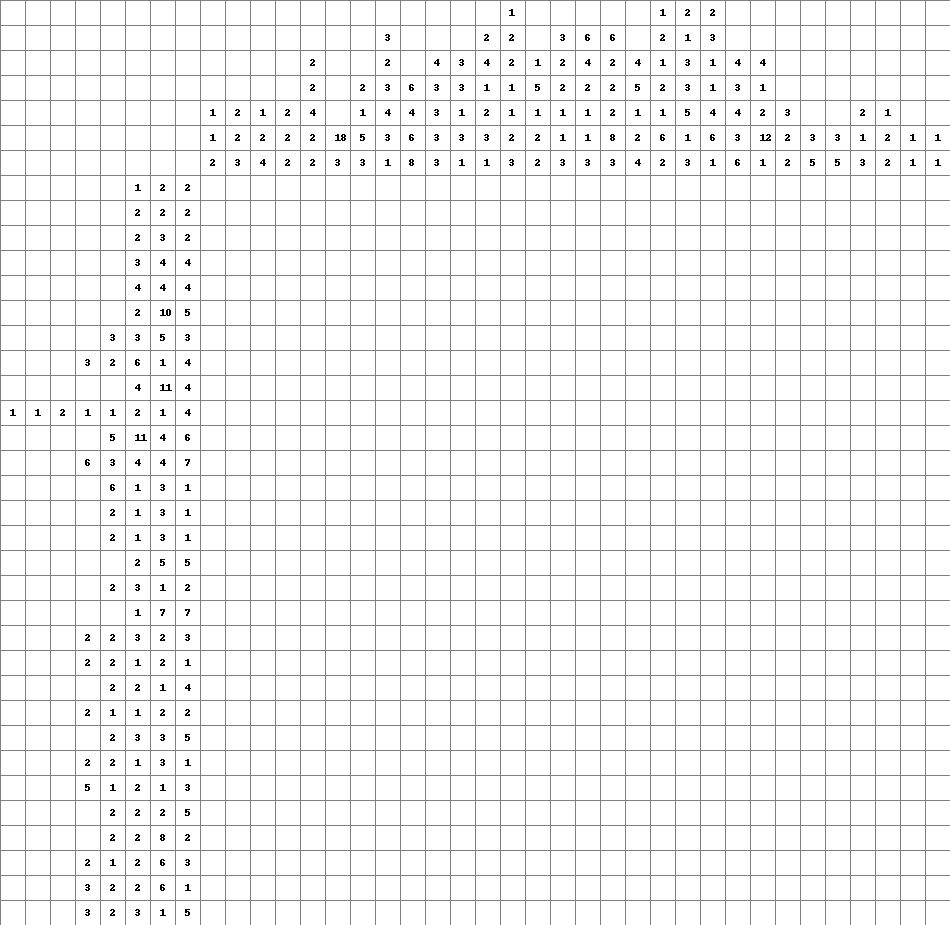

In [7]:
M.Mdraw()

In [11]:
mask = np.ones(M.shape,dtype=bool)

In [17]:
for i,c in enumerate(M.C):
    mask[i][c['len']-c['sum']:] = False
    mask[i][:c['len']] = False

In [48]:
def unmask(row, arr):
    (iones,) = np.where(row)
    lrow = iones + range(len(arr))
    rrow = lrow + arr
    shift = np.zeros(len(row),dtype = bool)    
    np.put(shift, lrow, True)
    np.put(shift, rrow, True)
    return shift ^ np.roll(shift,-1)
    
    

In [49]:
np.roll(np.array([1,2,3]),1)

array([3, 1, 2])

In [50]:
unmask(np.array([True,True,True,False,False,False]),np.array([1,2,1]))

[0 2 4] [1 4 5]
[ True  True  True False  True  True]


array([False, False,  True,  True, False, False])

In [24]:
np.array([True, False, True])# << 1

array([2, 0, 2])

In [ ]:
[1,2,2]
[1,0,0,0,1]

In [21]:
mask

array([[False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False,
        False, False, False],
       [False, False, False,

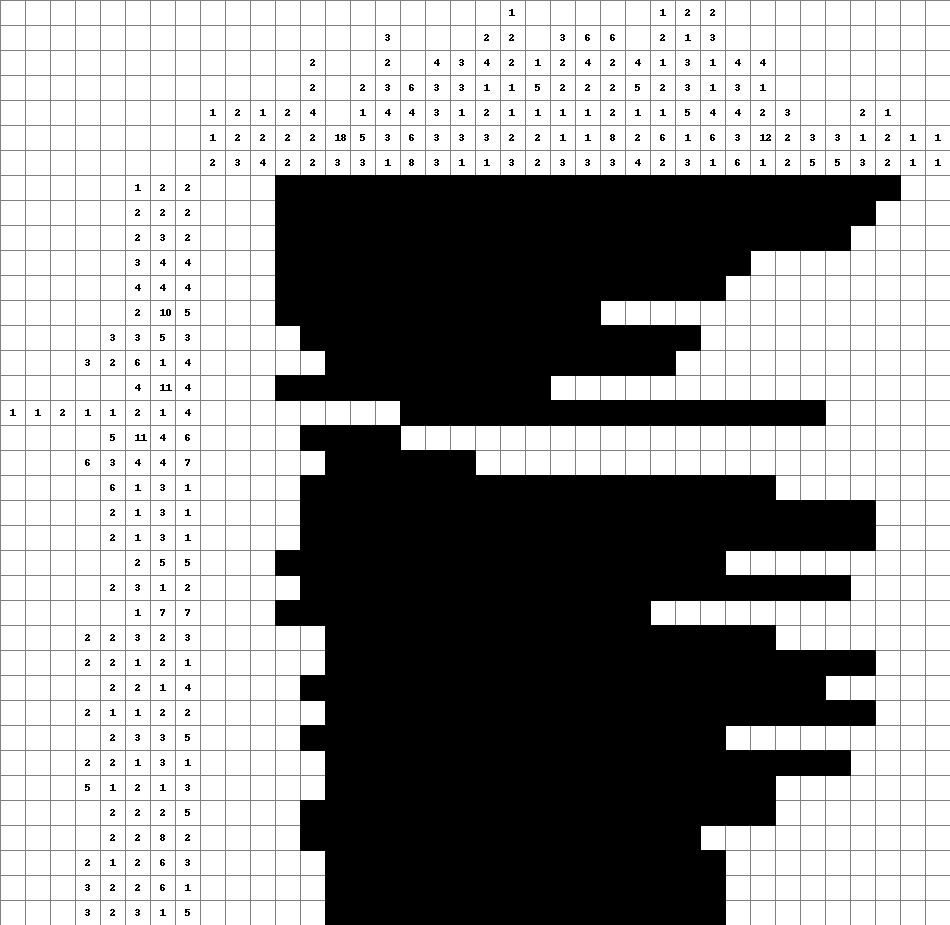

In [18]:
M.Mdraw(mask)

In [6]:
M.c

array([[ 0,  0,  0,  0,  0,  1,  2,  2],
       [ 0,  0,  0,  0,  0,  2,  2,  2],
       [ 0,  0,  0,  0,  0,  2,  3,  2],
       [ 0,  0,  0,  0,  0,  3,  4,  4],
       [ 0,  0,  0,  0,  0,  4,  4,  4],
       [ 0,  0,  0,  0,  0,  2, 10,  5],
       [ 0,  0,  0,  0,  3,  3,  5,  3],
       [ 0,  0,  0,  3,  2,  6,  1,  4],
       [ 0,  0,  0,  0,  0,  4, 11,  4],
       [ 1,  1,  2,  1,  1,  2,  1,  4],
       [ 0,  0,  0,  0,  5, 11,  4,  6],
       [ 0,  0,  0,  6,  3,  4,  4,  7],
       [ 0,  0,  0,  0,  6,  1,  3,  1],
       [ 0,  0,  0,  0,  2,  1,  3,  1],
       [ 0,  0,  0,  0,  2,  1,  3,  1],
       [ 0,  0,  0,  0,  0,  2,  5,  5],
       [ 0,  0,  0,  0,  2,  3,  1,  2],
       [ 0,  0,  0,  0,  0,  1,  7,  7],
       [ 0,  0,  0,  2,  2,  3,  2,  3],
       [ 0,  0,  0,  2,  2,  1,  2,  1],
       [ 0,  0,  0,  0,  2,  2,  1,  4],
       [ 0,  0,  0,  2,  1,  1,  2,  2],
       [ 0,  0,  0,  0,  2,  3,  3,  5],
       [ 0,  0,  0,  2,  2,  1,  3,  1],
       [ 0,  0, 

In [43]:
import random
nagent = 3000
nchildren = 10000
niteration = 100
mrate = 0.05

def crossover(agents,nchildren , M = 2):
        
    Aindicies = np.random.choice(range(len(agents)),size=((nchildren+1)*M,2))
    Aindicies = Aindicies[Aindicies[:,0] != Aindicies[:,1]][:nchildren]

    if(len(Aindicies) != nchildren):
        return crossover(agents,nchildren,M=M+1)
        
    shx,shy = agents[0].shape
    K = np.random.randint(0, shx-2,size = nchildren)
    L = np.random.randint(K+1, shx,size = nchildren)
    M = np.random.randint(0, shy-2,size = nchildren)
    N = np.random.randint(M+1, shy,size = nchildren)
    
    children = agents[Aindicies]
    for index in range(len(children)):
        k,l,m,n = K[index],L[index],M[index],N[index]
        children[index][0][k:l,m:n] = children[index][1][k:l,m:n]
    return [mutate(children[:,0])]

def mutate(agent):
  Cells = np.random.rand(*agent.shape) < mrate
  return Cells ^ agent

def Run( niteration, agents = np.zeros((nagent, *M.shape),dtype = bool) ):
  for _ in range(niteration):
    agents = np.vstack([mutate(agents)]+crossover(agents,nchildren))     
    cost = M.advcost(agents)
    indices = np.argsort(cost)[:nagent]
    agents = agents[np.argsort(cost)[:nagent]]
    print(min(cost))
  return agents

import pandas as pd
import numpy as np
df = pd.read_csv('nonogram.csv')
M = Matrix(df.iloc[2494])

M.onezero = M.onezero2
#Agents = Run(30,np.zeros((2,*M.shape),dtype = bool))

In [44]:
Stats(lambda : Run(10,np.zeros((2,*M.shape),dtype = bool)))

992.0
717.0
582.0
527.25
502.875
509.33333333333337
511.0
521.0
534.0
556.0
         106826 function calls (99037 primitive calls) in 3.603 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      620    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
       20    0.000    0.000    0.000    0.000 {method 'insert' of 'list' objects}
       20    0.000    0.000    0.000    0.000 {method 'remove' of 'list' objects}
      600    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
     1104    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
      600    0.001    0.000    0.001    0.000 {built-in method builtins.any}
      600    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
     1495    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
       10    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
     1594    0.000

In [34]:
Stats(lambda : Run(10,np.zeros((2,*M.shape),dtype = bool)))

971.0
712.0
591.0
521.0
506.0
507.0
528.0
540.4
541.9
570.0
         107222 function calls (99415 primitive calls) in 3.591 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      620    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
       20    0.000    0.000    0.000    0.000 {method 'insert' of 'list' objects}
       20    0.000    0.000    0.000    0.000 {method 'remove' of 'list' objects}
      600    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
     1118    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
      600    0.001    0.000    0.001    0.000 {built-in method builtins.any}
      600    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
     1498    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
       10    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
     1606    0.000    0.000    0.0

In [15]:
c1[c1!=0]  #@ np.array([1,1,0])

array([1, 2, 2])

In [19]:
C1 = np.array([[1], [2], [2]])

In [20]:
C1 @ np.array

array([[1],
       [2],
       [2]])

In [28]:
L = np.array([s['len'] for s in M.C])
S = np.array([s['sum'] for s in M.C])

In [30]:
S-L

array([ 2,  3,  4,  8,  9, 14, 10, 11, 16,  5, 22, 19,  7,  3,  3,  9,  4,
       12,  7,  3,  5,  3,  9,  4,  7,  7, 10,  9,  9,  9])

In [38]:
A = np.zeros(M.shape,dtype = bool)

In [43]:
A[:,S-L]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False,

In [ ]:
M.Mdraw(Agents[0])

In [9]:
nenvs = 100
nagent = 30
nchildren = 100
niteration = 100000
mrate = 0.02
from matplotlib import pyplot as plt
import seaborn as sns

def crossover2D(agents,nchildren, M = 3):
    nenvs = agents.shape[0]
    totalchildren = nenvs * nchildren
    
    Aindicies = np.random.choice(range(len(agents[0])),size=((totalchildren+1)*M,2))
    Aindicies = Aindicies[Aindicies[:,0] != Aindicies[:,1]][:totalchildren]

    if(len(Aindicies) != totalchildren):
        return crossover2D(agents,nchildren,M=M+1)
    
    Aindicies = Aindicies.reshape((nenvs,nchildren,2))
    
    shx,shy = agents[0,0].shape
    K = np.random.randint(0, shx-2,size = (nenvs,nchildren))
    L = np.random.randint(K+1, shx,size = (nenvs,nchildren))
    M = np.random.randint(0, shy-2,size = (nenvs,nchildren))
    N = np.random.randint(M+1, shy,size = (nenvs,nchildren))
    
    envindicies = np.array(range(nenvs))
    envindicies = np.tile(envindicies, (2,nchildren,1)).T
    children = agents[envindicies,Aindicies]
    for index1 in range(nenvs):
        for index2 in range(nchildren):
            k,l,m,n = K[index1][index2],L[index1][index2],M[index1][index2],N[index1][index2]
            children[index1][index2][0][k:l,m:n] = children[index1][index2][1][k:l,m:n]
    return mutate(children[:,:,0])

def mutate(agent):
  Cells = np.random.rand(*agent.shape) < mrate
  return Cells ^ agent

def Run( niteration, agents = np.zeros((nenvs,nagent, *M.shape),dtype = bool) ):
  for _ in range(niteration):
    agents = np.concatenate([mutate(agents),crossover2D(agents,nchildren)],axis =1)  
    cost = M.advcost(agents.reshape(-1,*agents.shape[-2:])).reshape(agents.shape[:2])
    
    envindicies = np.array(range(nenvs))
    envindicies = np.tile(envindicies, (nagent,1)).T
    indicies = np.dstack([envindicies,cost.argsort()[:,:nagent]])    
    agents = agents[envindicies,cost.argsort()[:,:nagent]]

    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize = (16,3))
    sns.heatmap(np.sum(np.sum(agents,axis= 0),axis= 0), ax=ax1)
    sns.heatmap(np.sum(agents[0],axis= 0), ax=ax2)
    sns.heatmap(np.sum(agents[1],axis= 0), ax=ax3)
    plt.show()
    
    print(np.min(cost))
    
  return agents

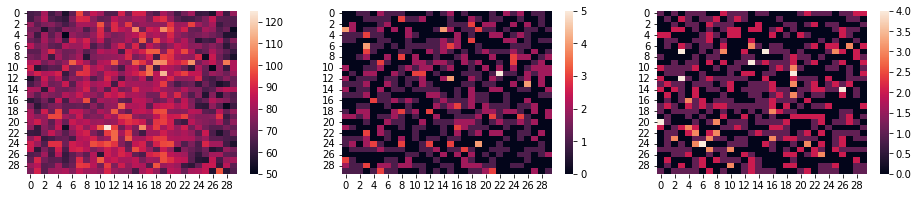

1369.0


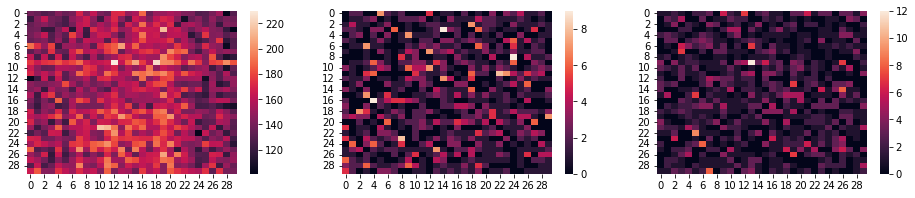

1127.0


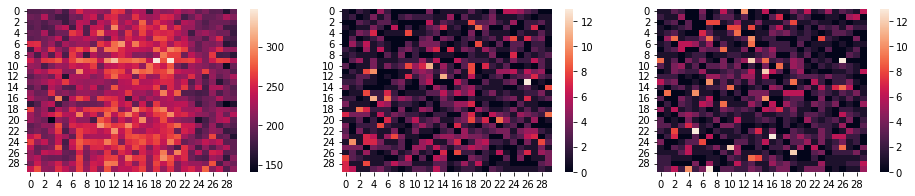

947.0


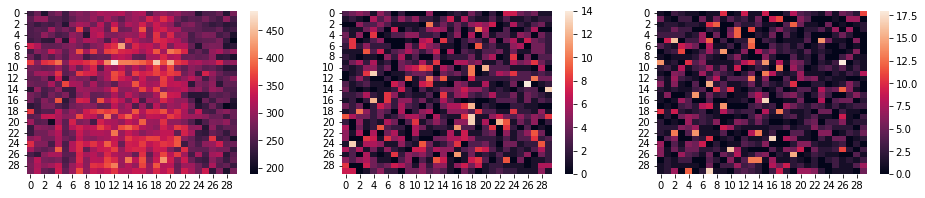

771.0


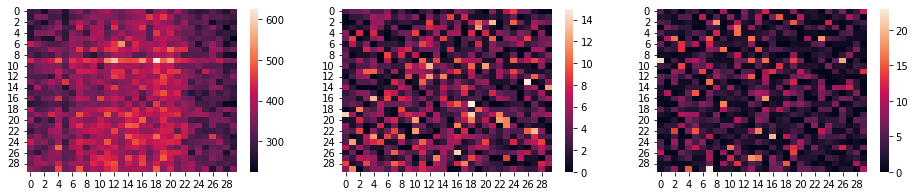

677.0


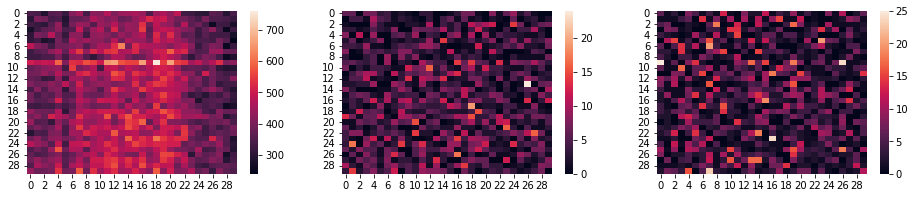

602.4


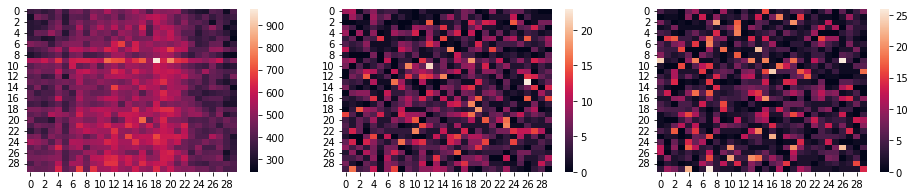

546.0


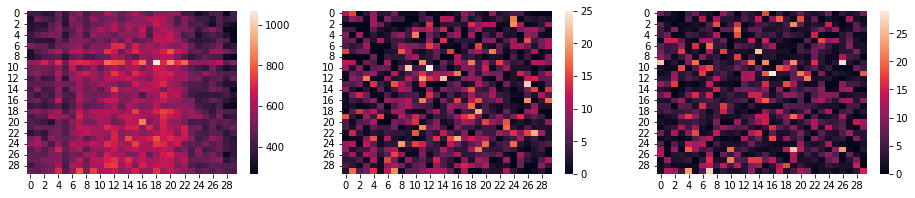

524.0


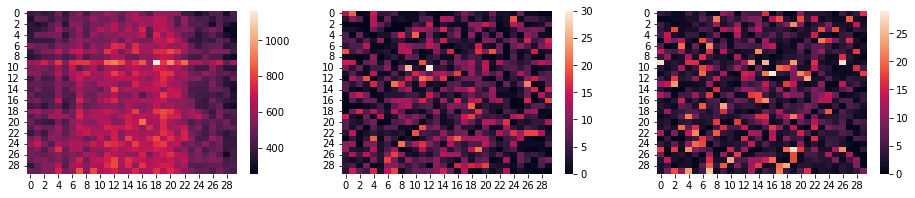

493.0


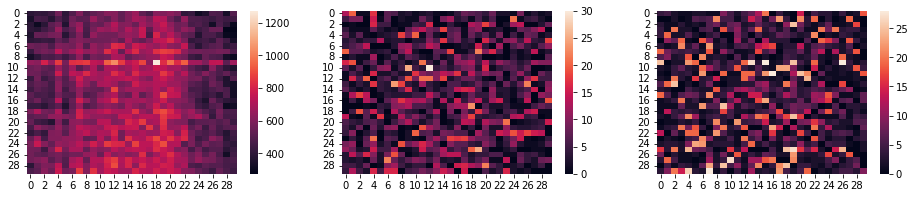

479.0


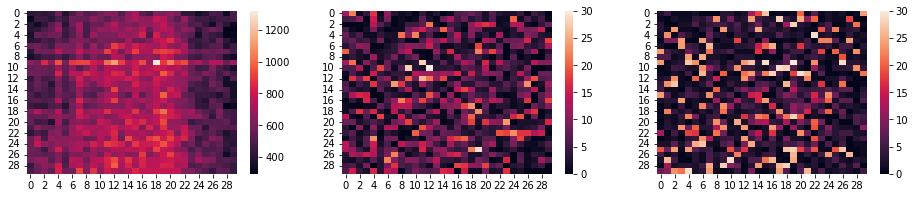

476.25


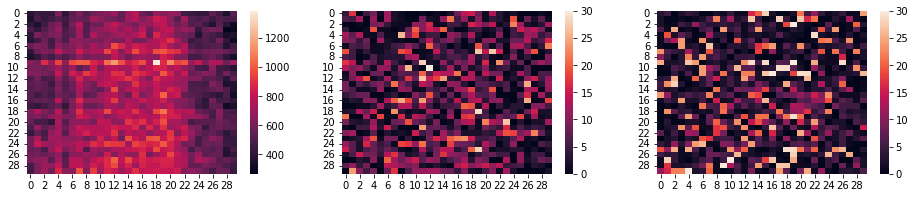

478.5


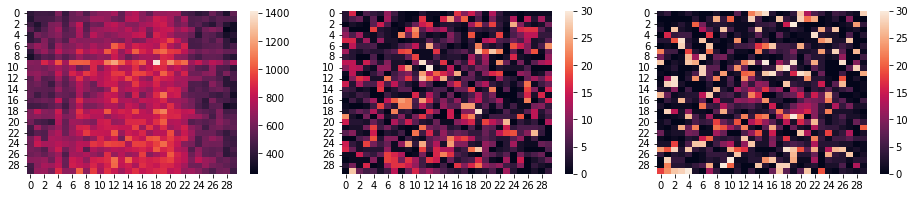

467.0


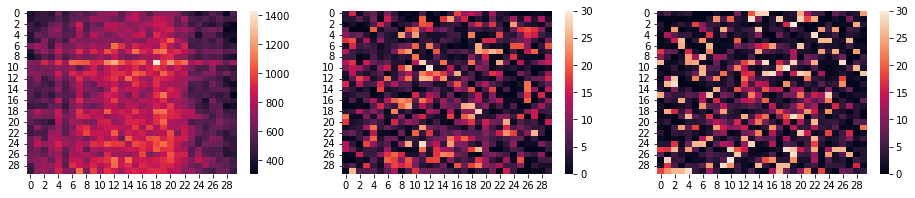

464.0


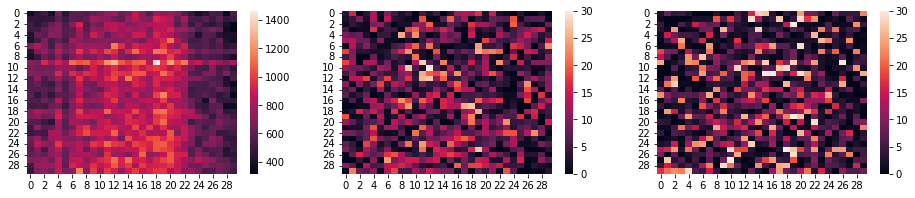

457.0


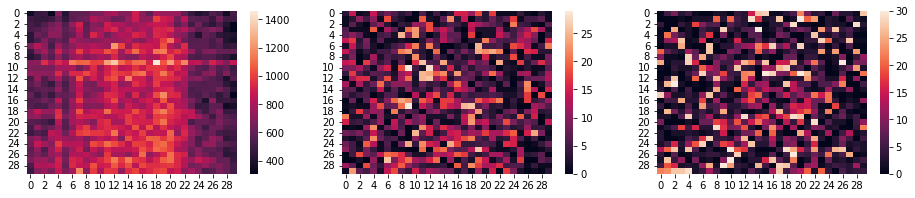

459.0


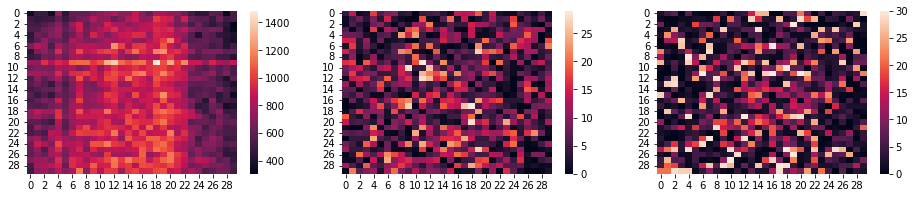

435.0


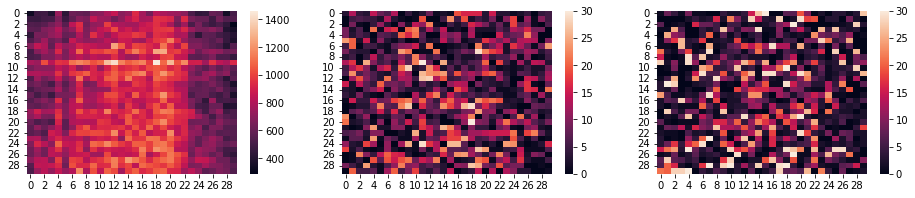

439.0


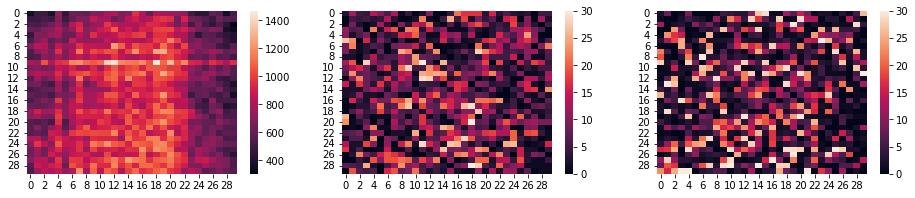

444.0


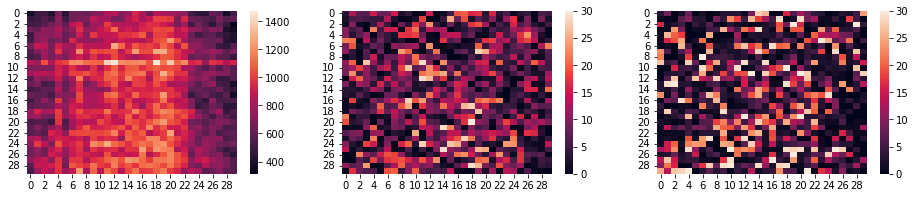

435.0


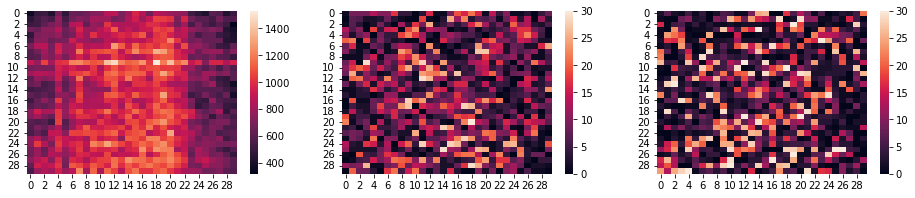

434.0


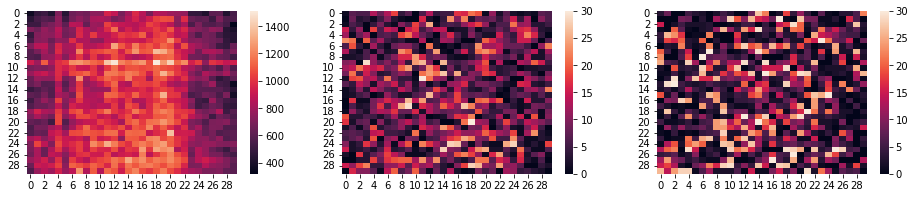

453.0


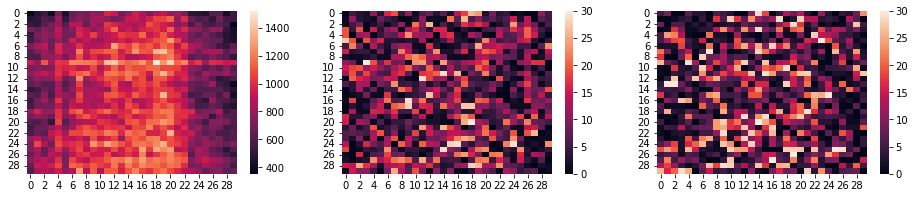

433.91666666666663


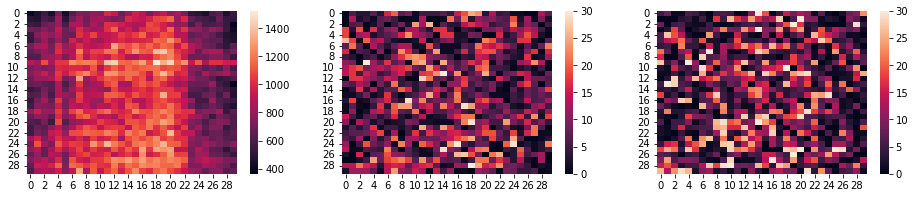

430.84444444444443


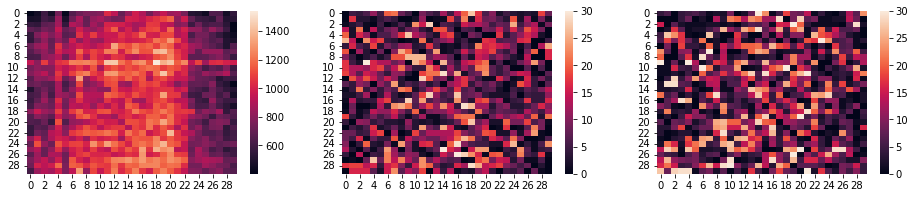

428.0


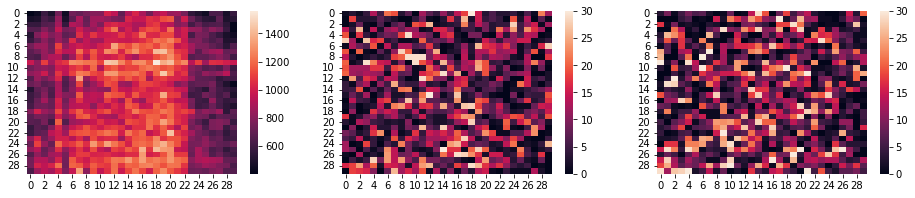

437.4545454545455


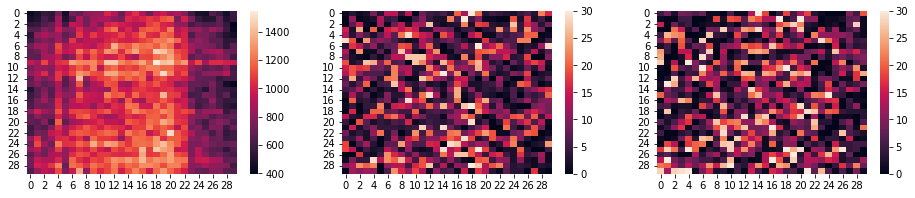

428.55555555555554


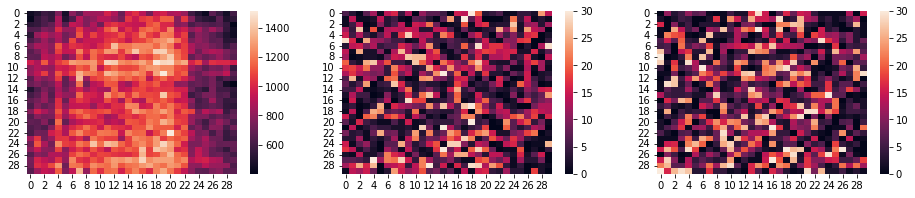

439.55555555555554


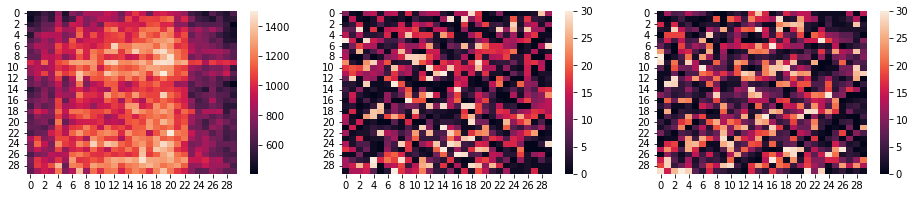

454.2


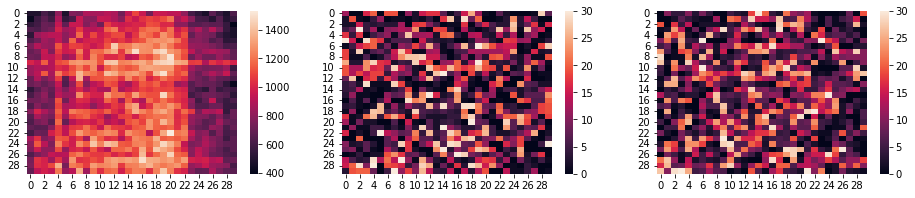

450.9090909090909


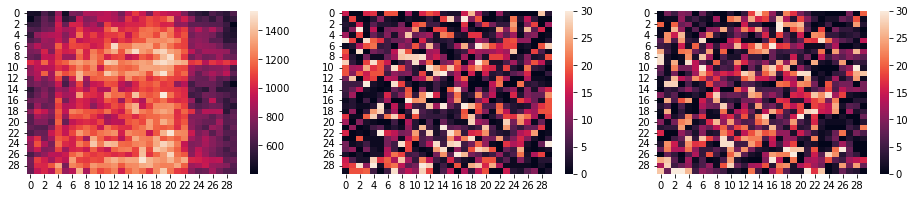

447.4


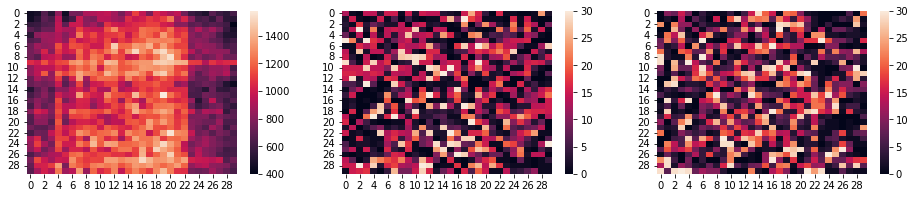

459.0


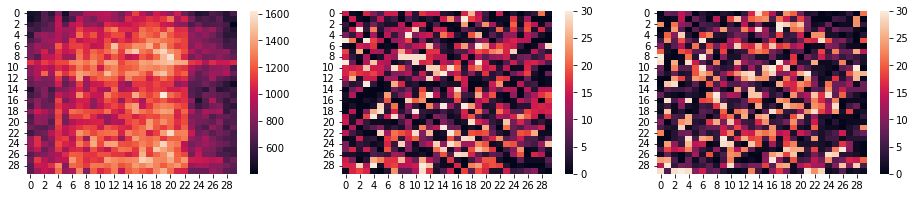

464.6


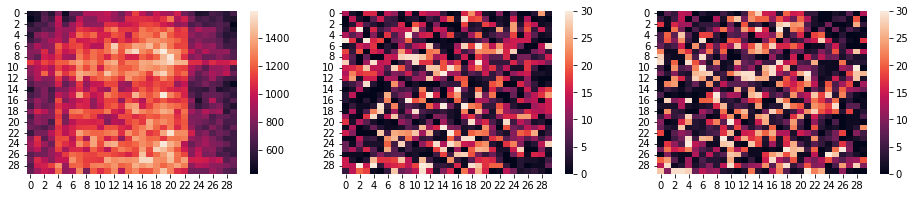

464.0


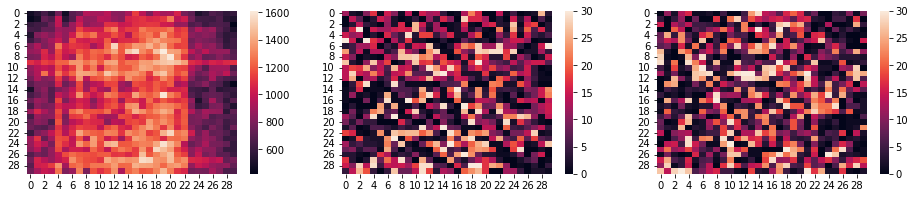

454.83441558441564


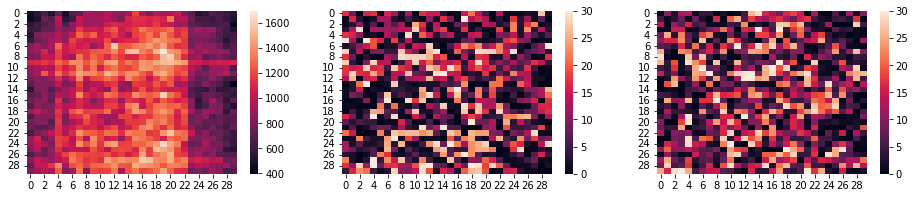

460.6


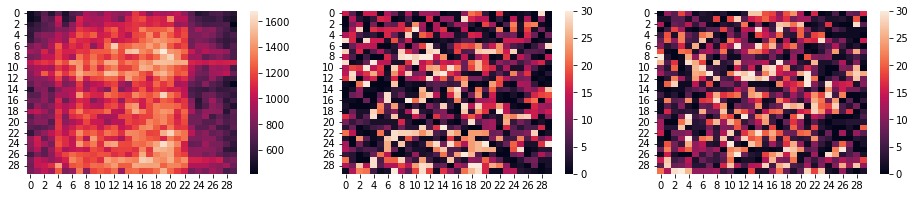

453.375


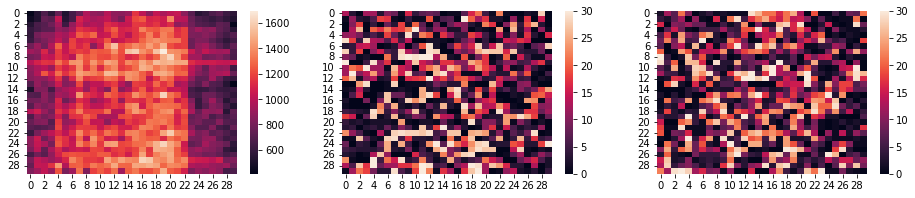

465.01984126984127


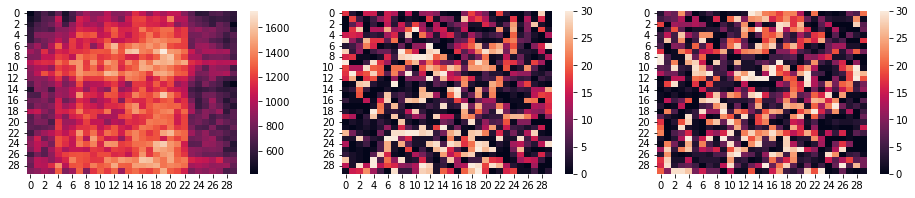

461.0


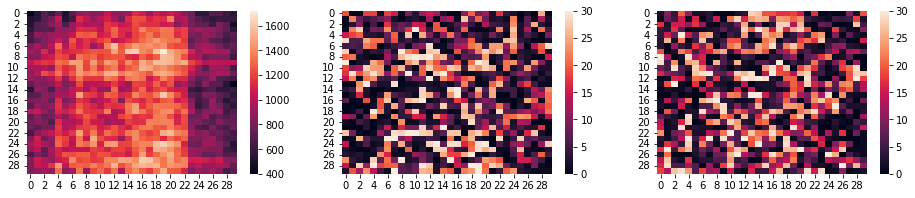

442.0


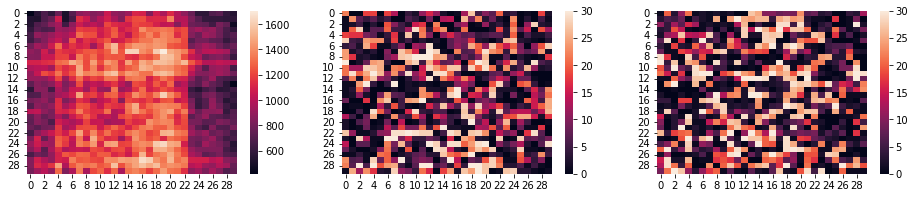

449.0


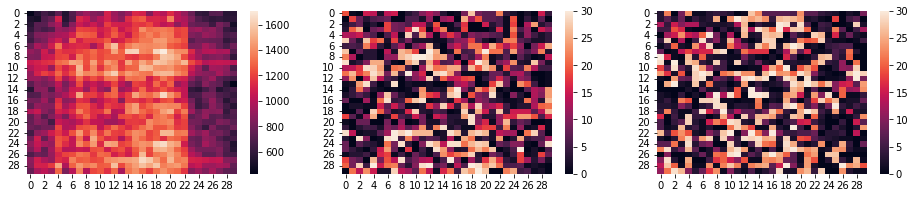

472.694493006993


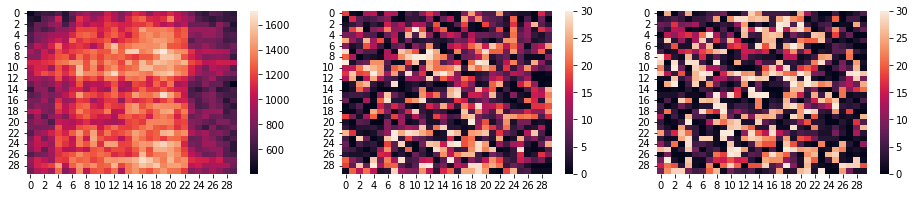

467.0


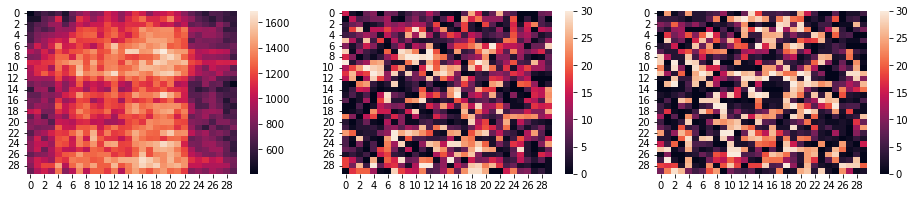

449.1818181818182


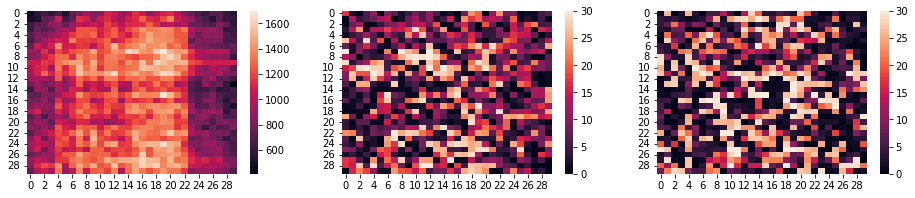

460.0


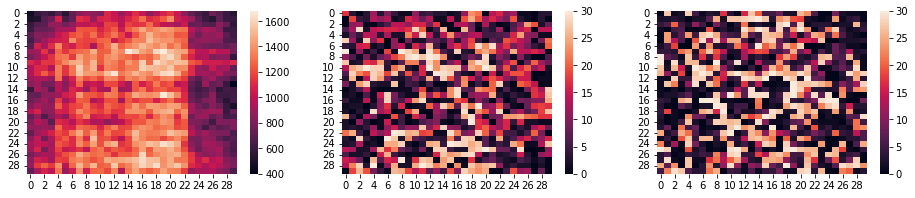

456.5


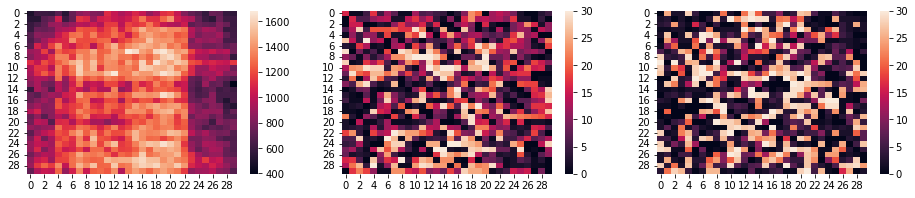

459.0


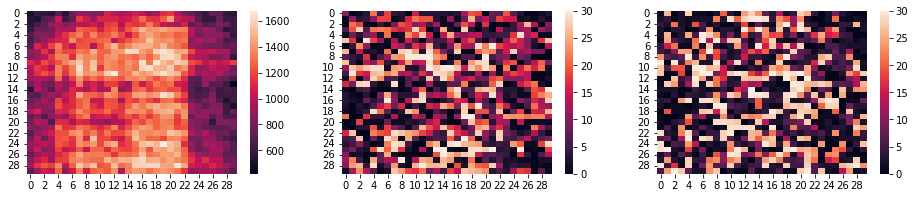

461.0


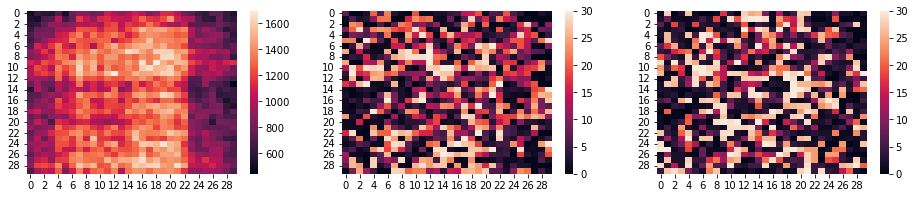

457.57575757575756


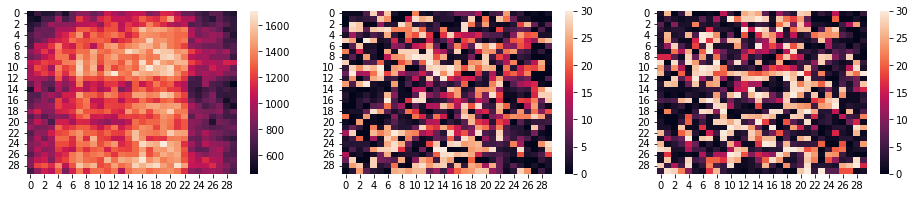

458.4060606060606


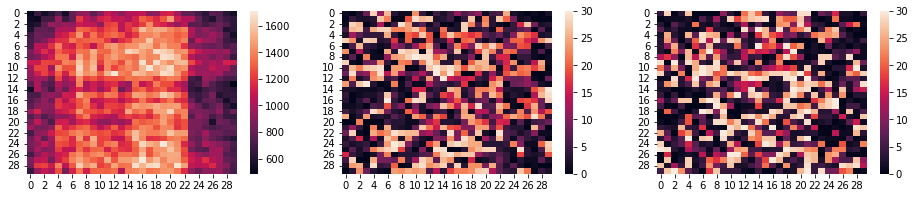

452.0


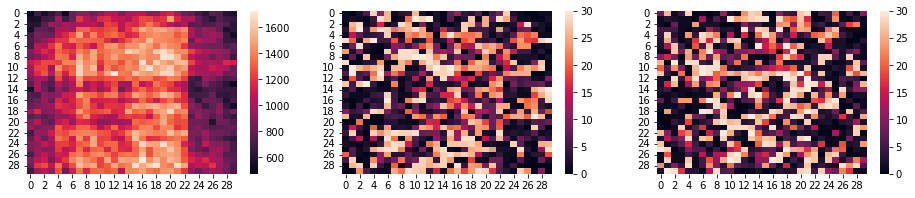

456.01666666666665


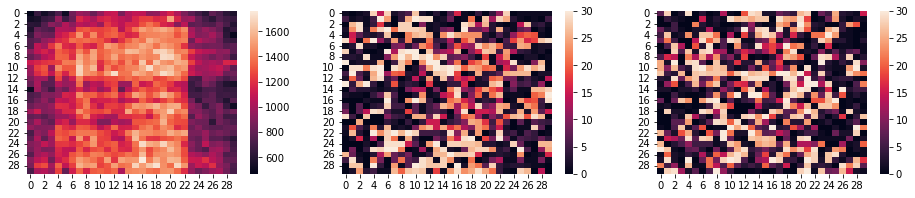

455.921568627451


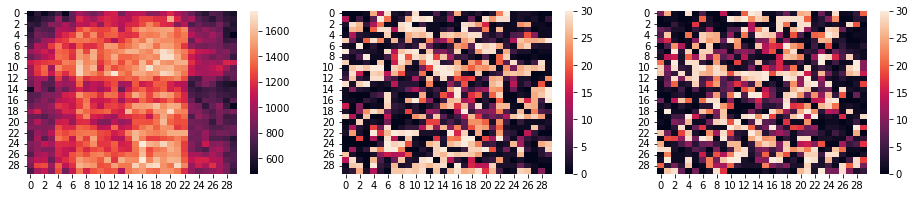

457.57575757575756


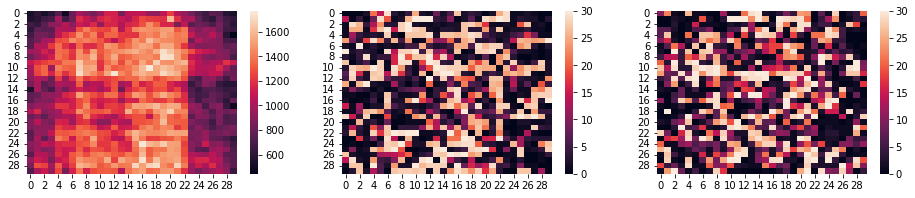

447.7305194805195


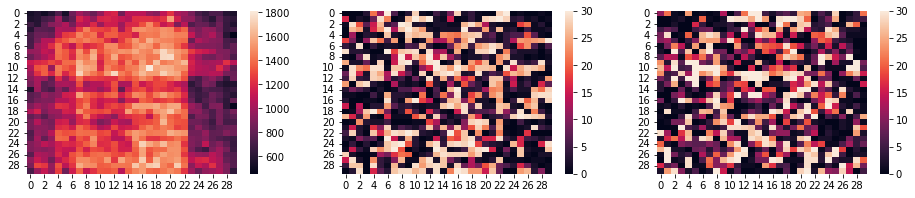

447.9237012987013


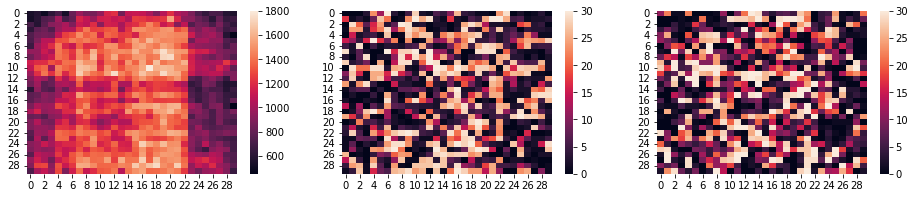

466.0


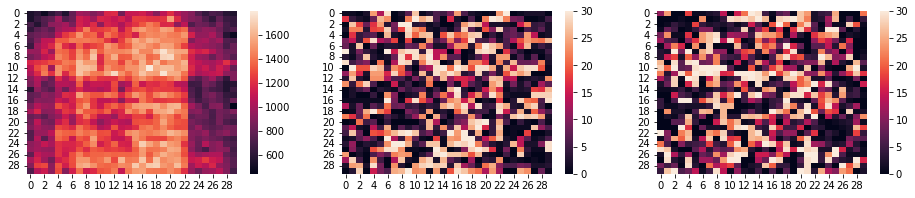

465.0


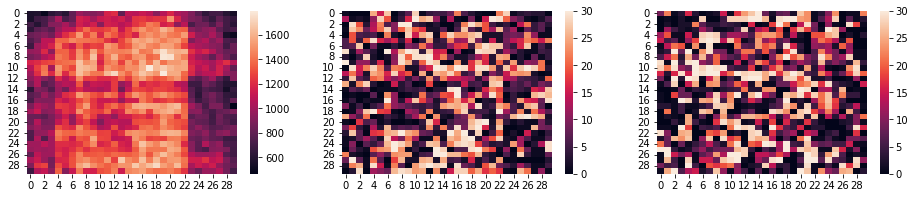

454.55555555555554


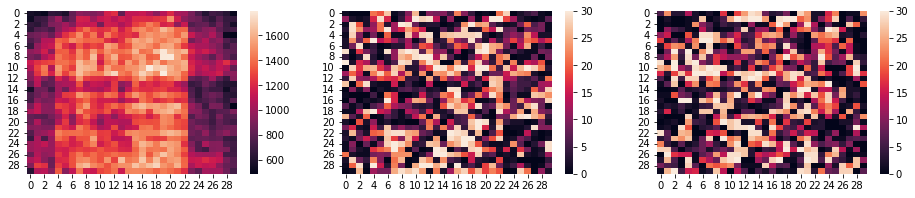

478.31111111111113


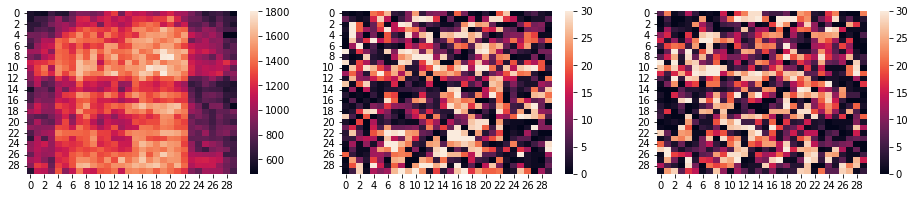

465.42857142857144


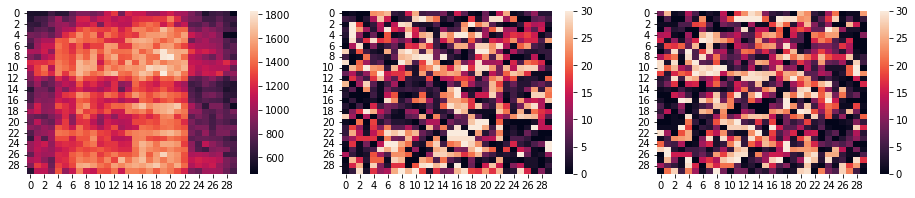

450.0


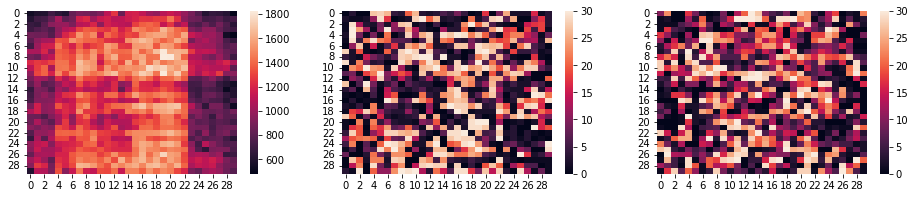

465.9642857142857


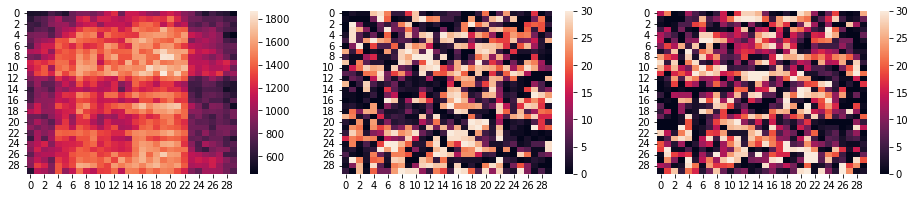

461.42857142857144


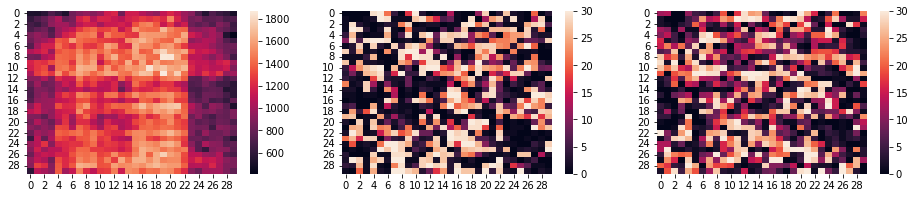

467.6363636363636


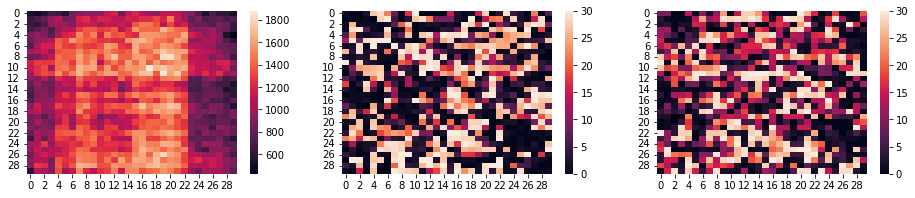

458.0


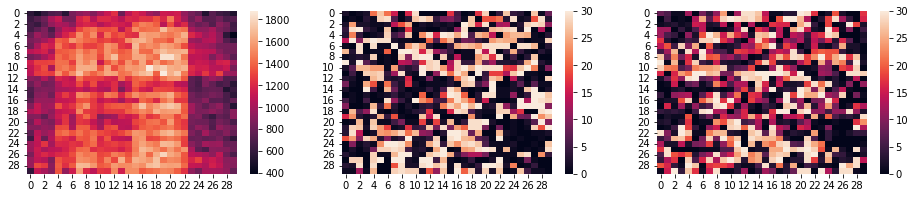

452.79924242424244


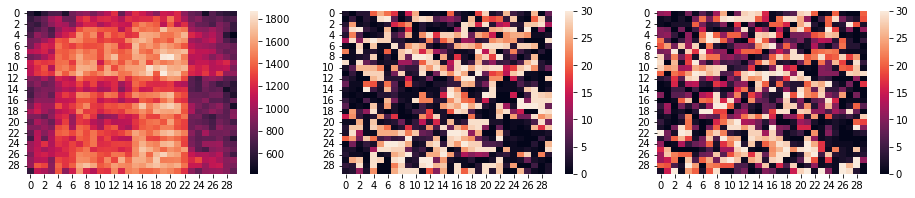

456.70833333333337


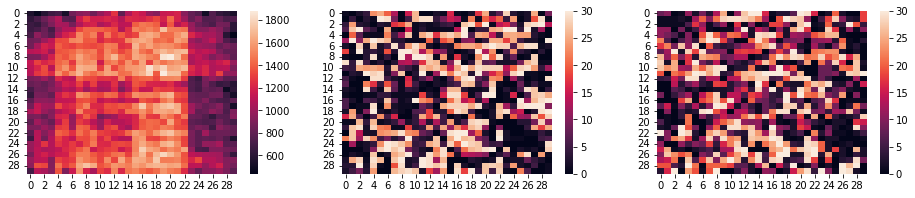

472.0


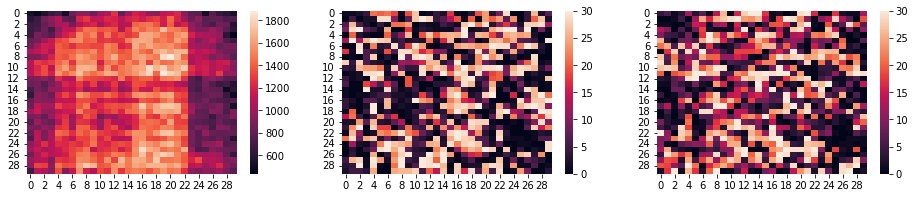

464.0


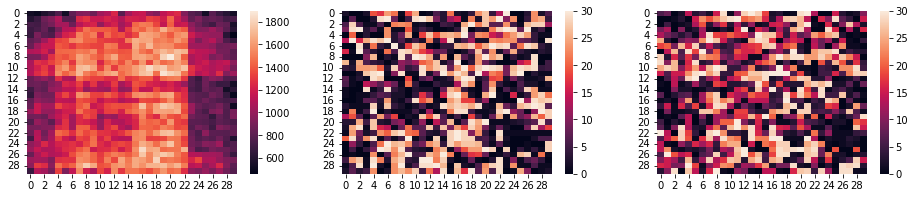

439.0


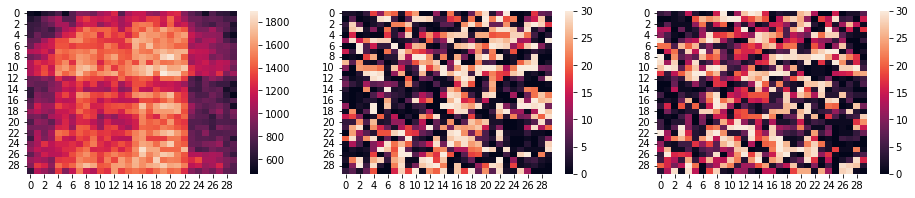

452.81944444444446


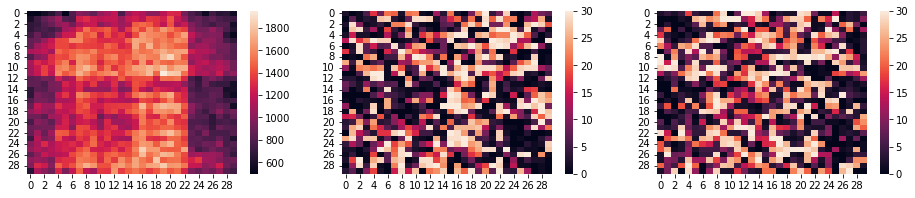

465.77777777777777


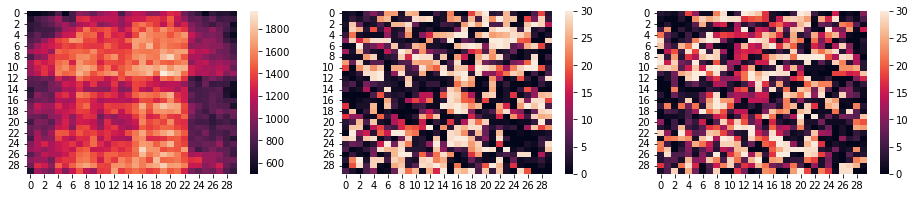

466.27922077922074


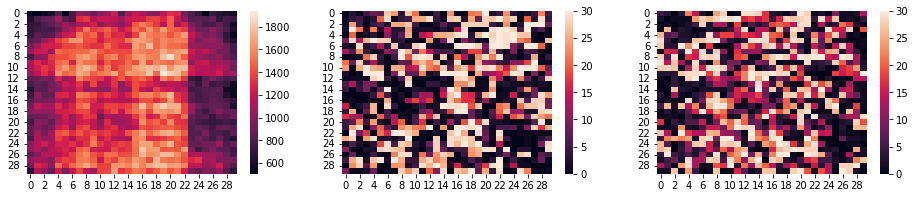

460.0


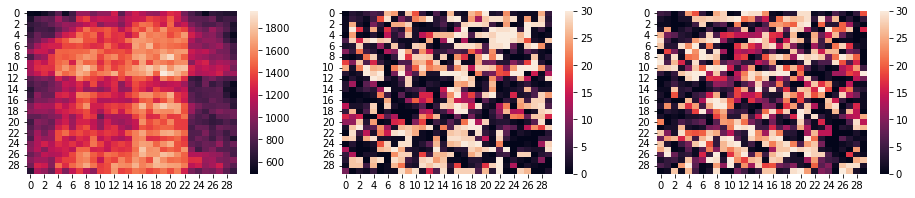

453.5


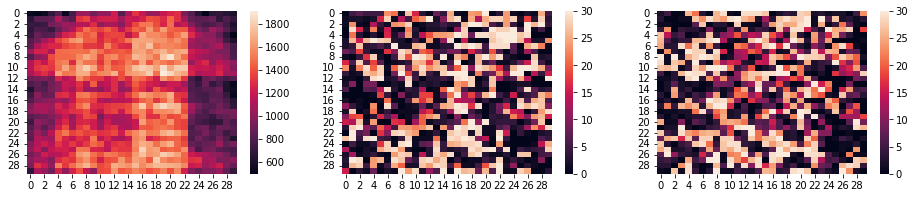

463.5


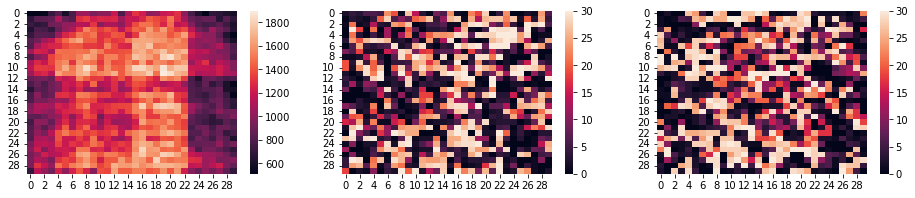

445.2352941176471


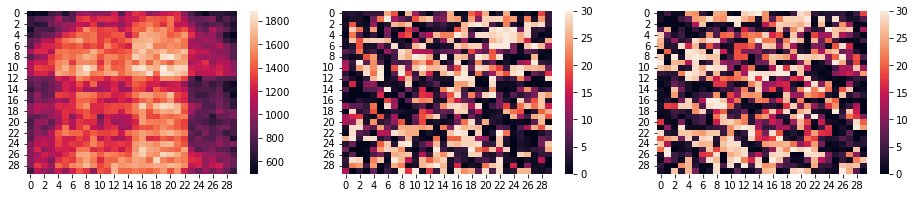

454.55555555555554


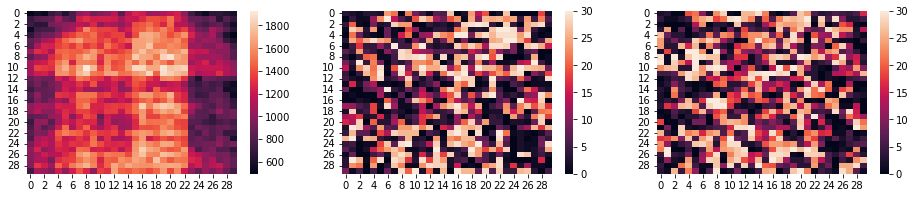

448.72142857142853


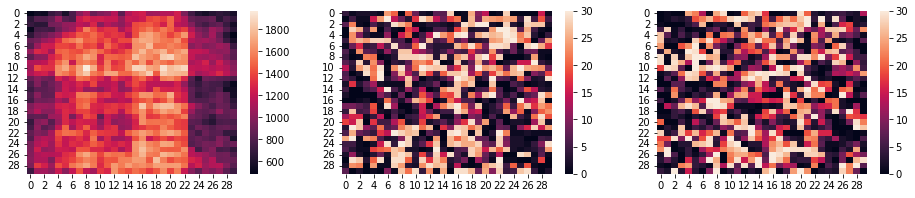

450.5238095238095


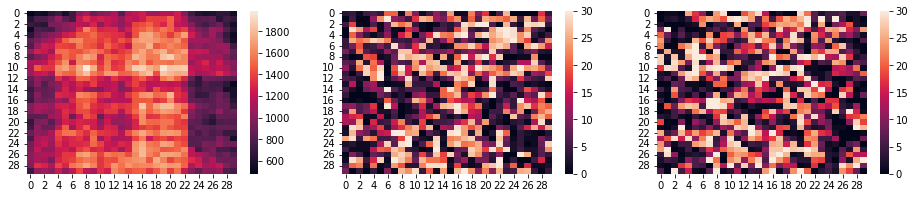

453.4145299145299


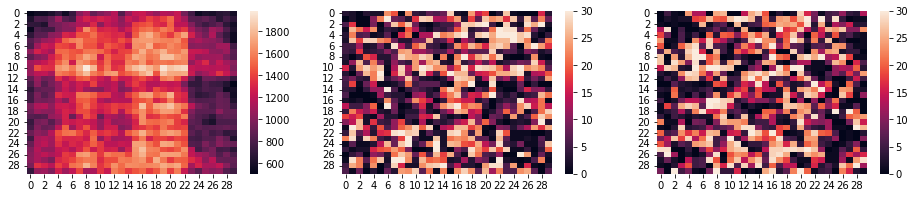

475.25


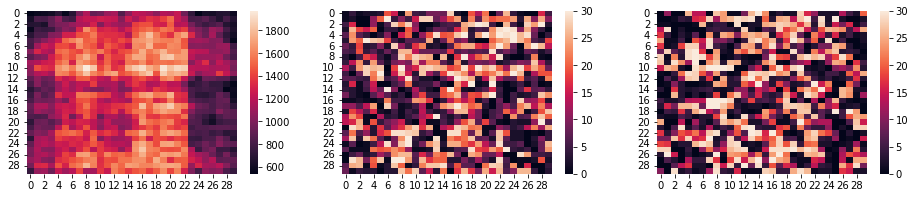

462.0


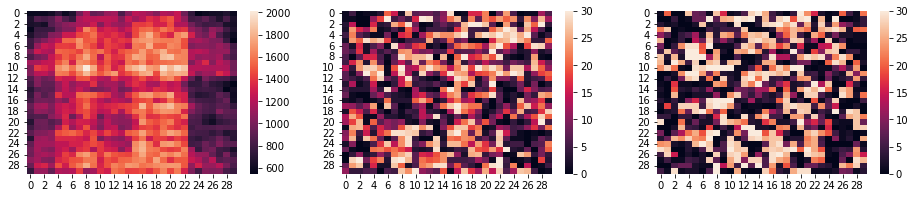

454.0


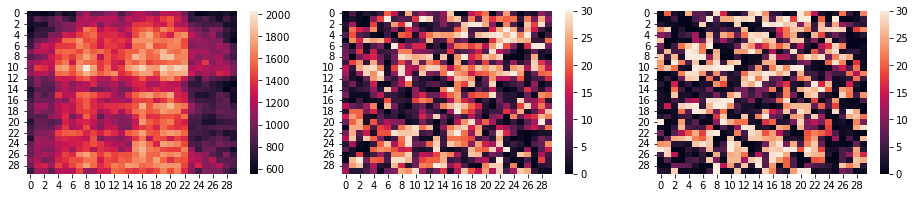

463.25


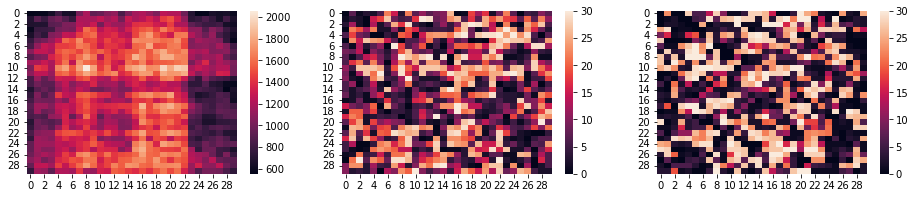

468.33333333333337


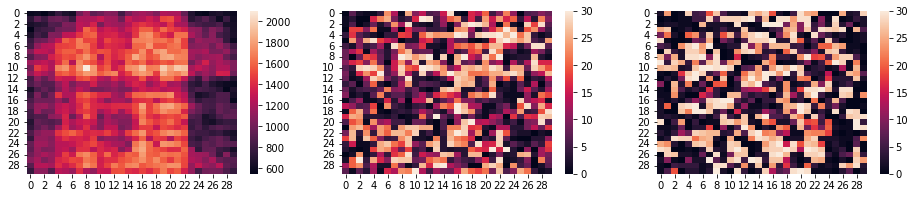

463.375


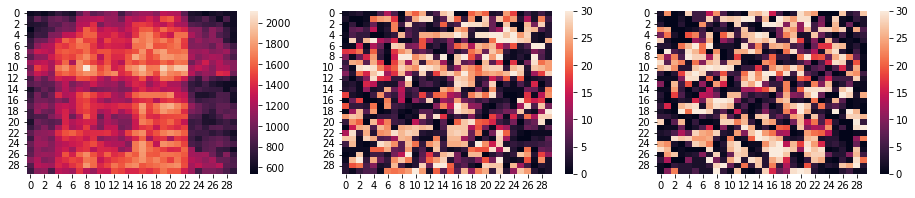

460.1666666666667


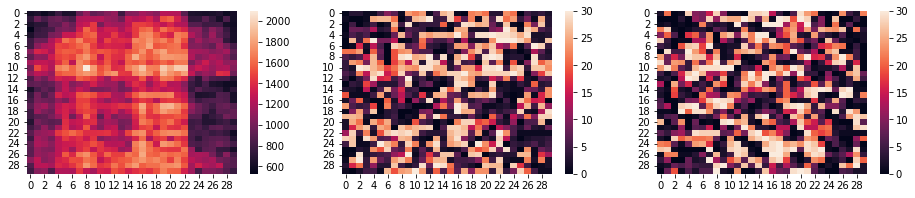

467.1666666666667


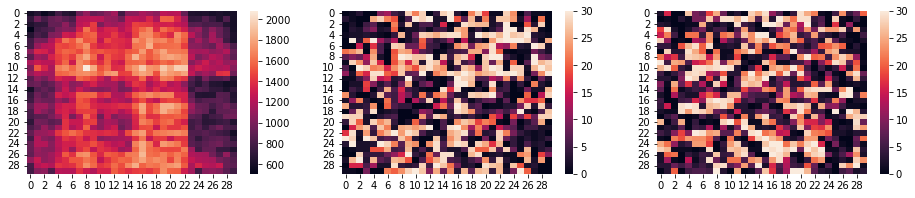

452.5


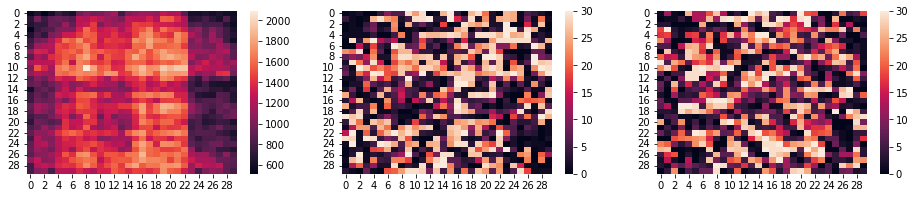

446.5625


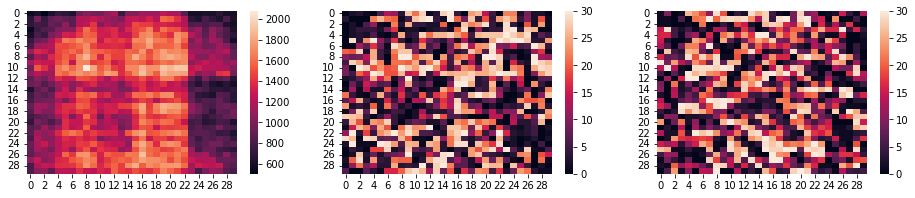

456.0


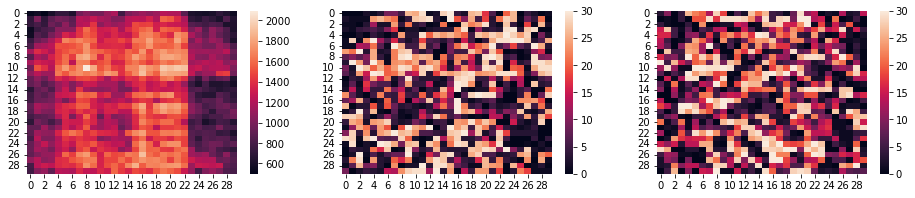

428.0


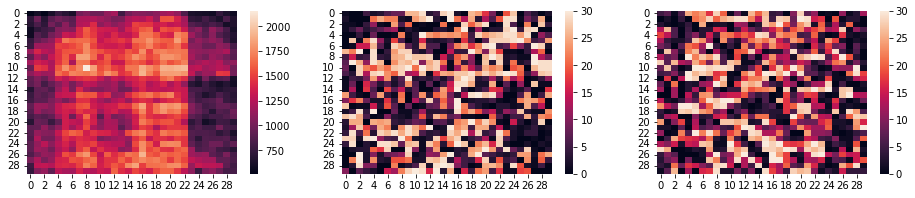

442.0


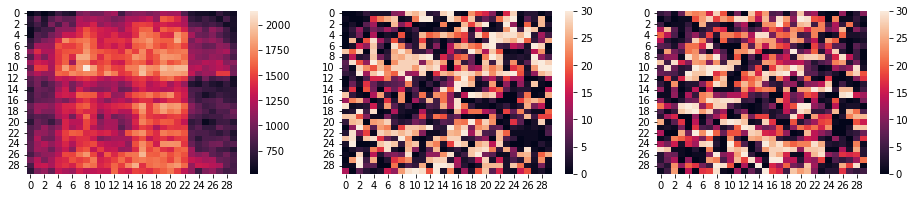

462.0


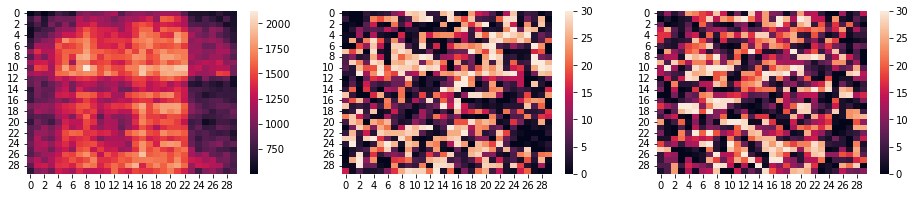

468.0


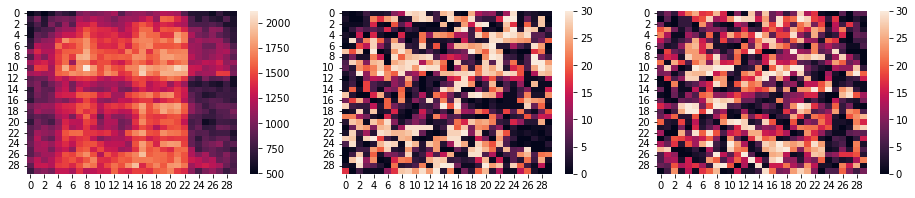

465.8461538461538


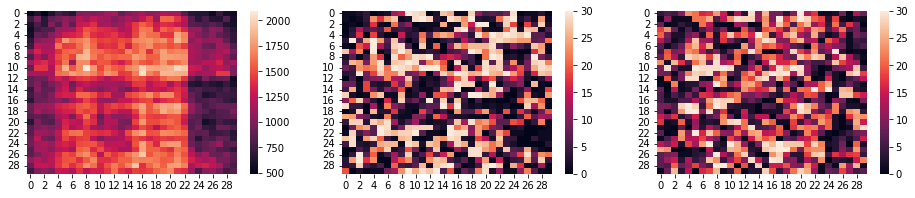

448.3636363636364


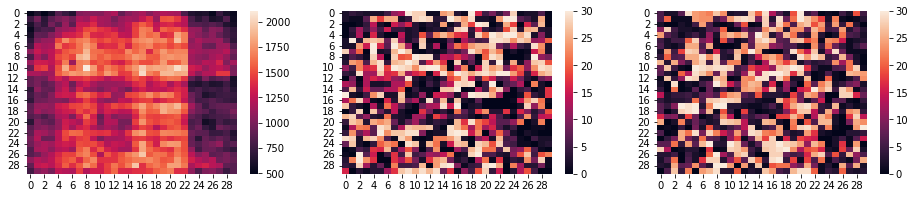

461.25


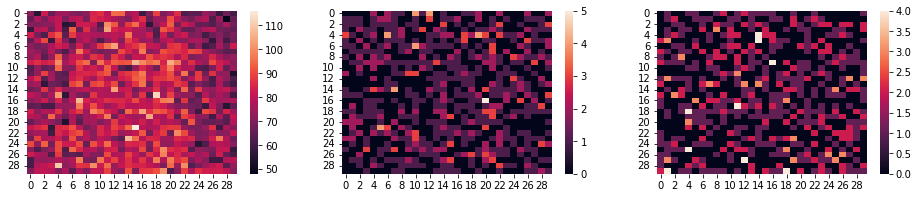

1281.0


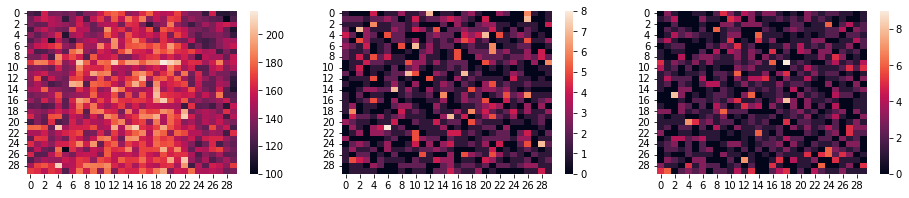

1100.0


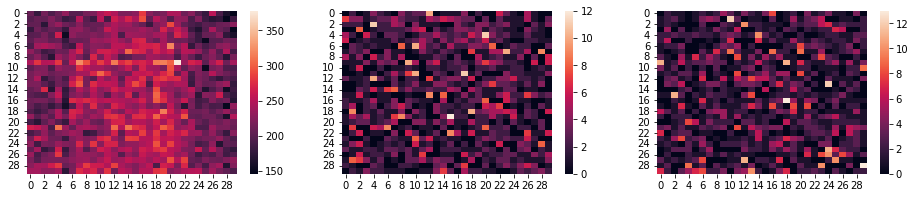

884.0


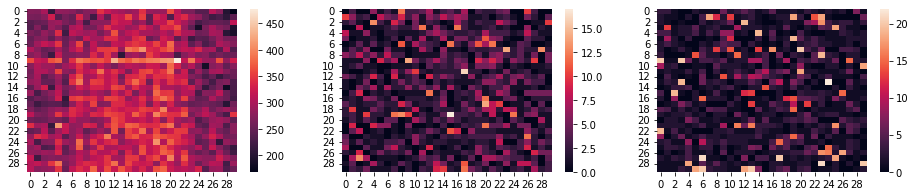

772.0


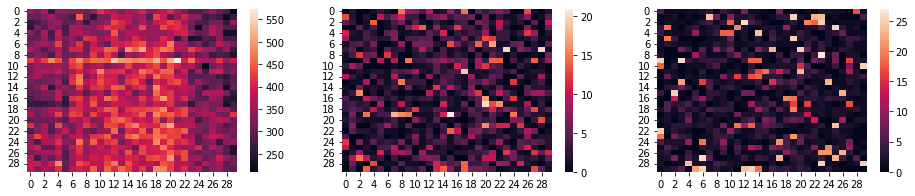

672.0


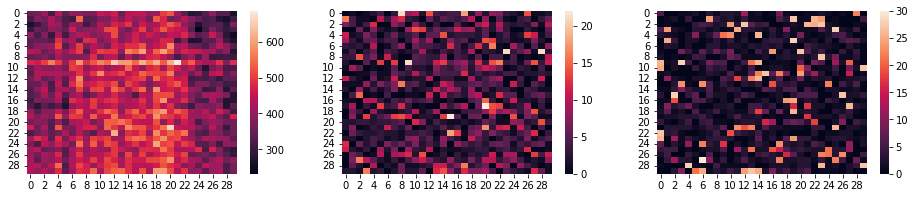

604.0


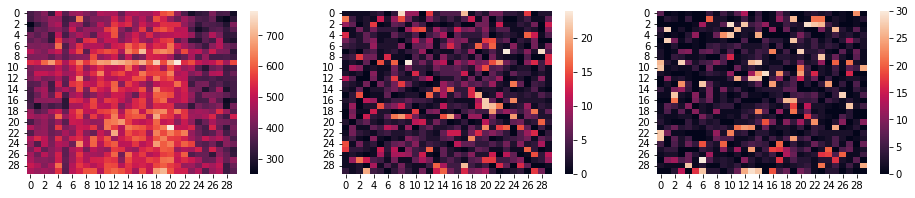

547.0


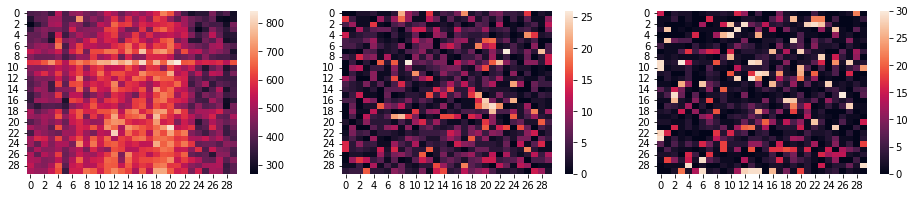

526.2


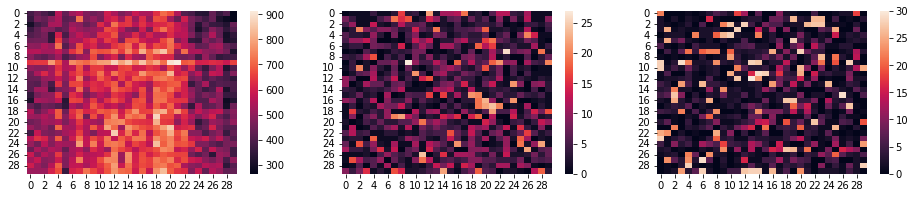

507.66666666666663


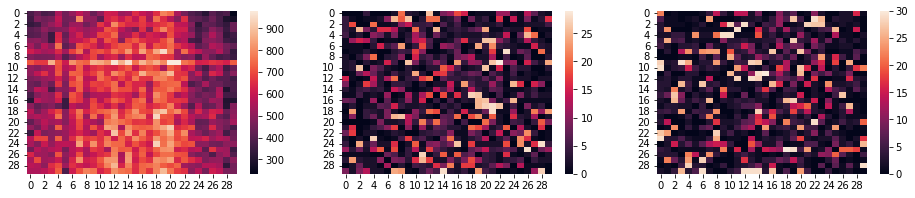

493.0


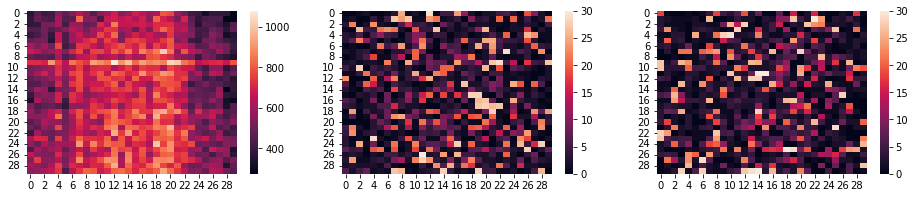

471.0


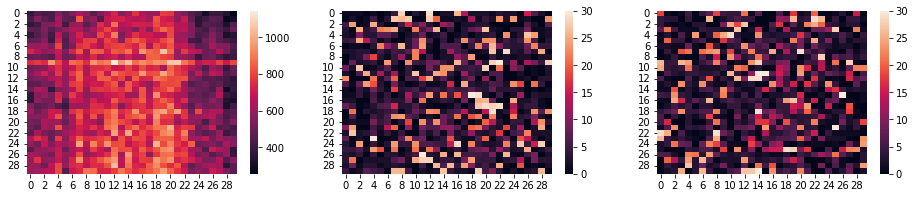

469.0


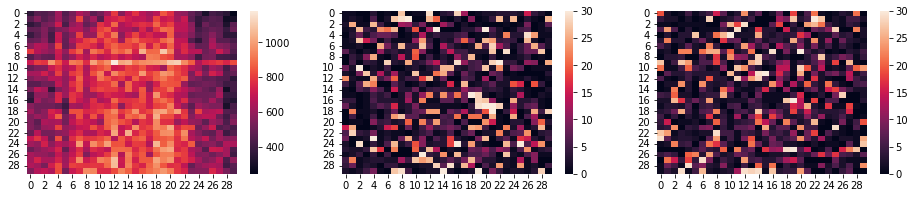

463.5


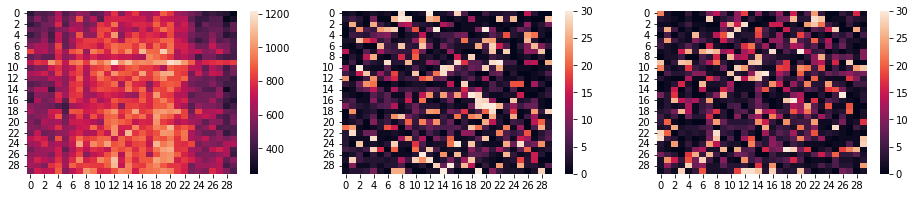

452.5


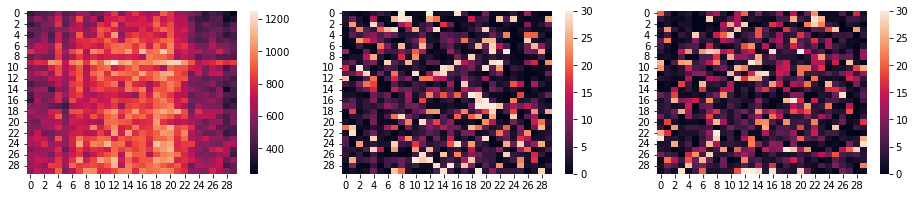

457.0


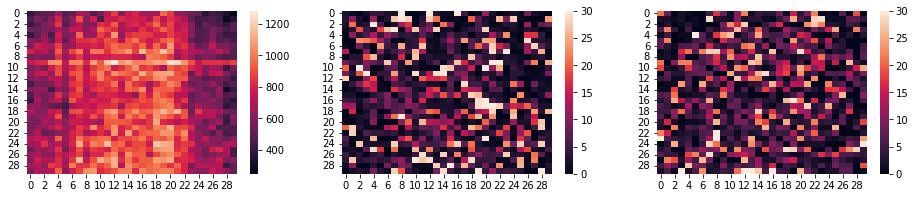

446.42857142857144


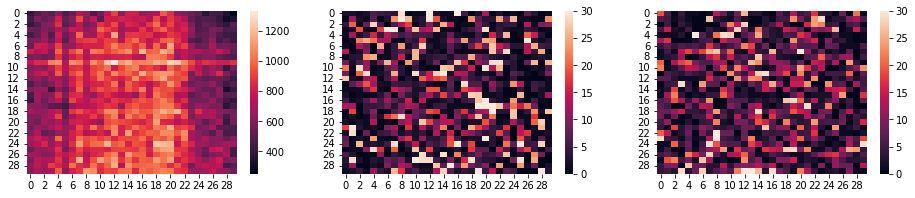

450.0


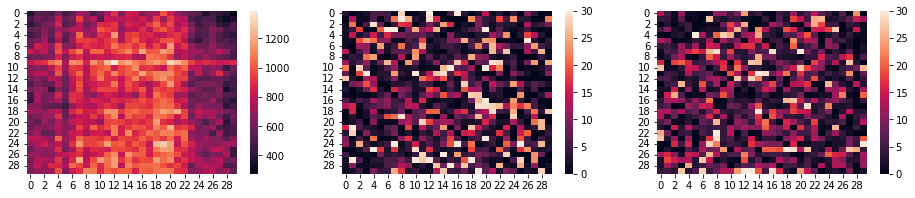

454.25


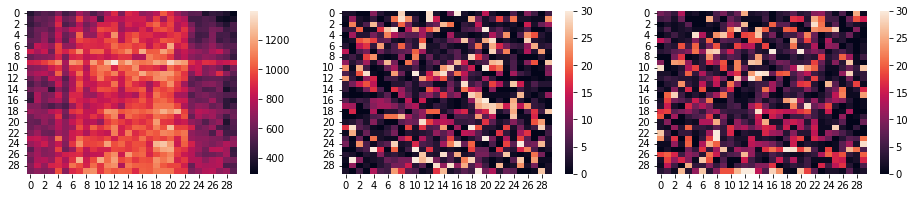

430.03907203907204


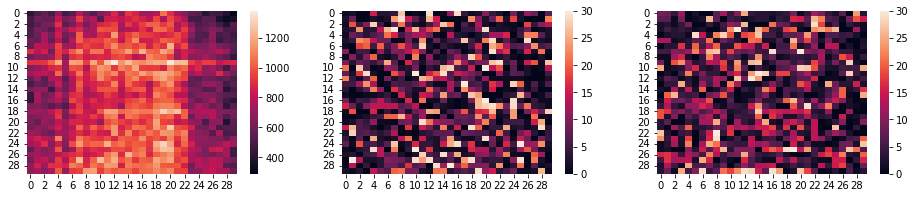

452.8809523809524


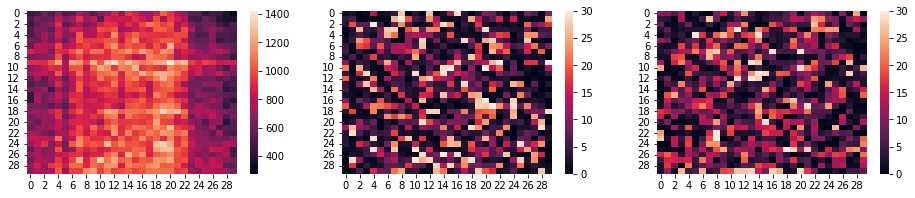

454.625


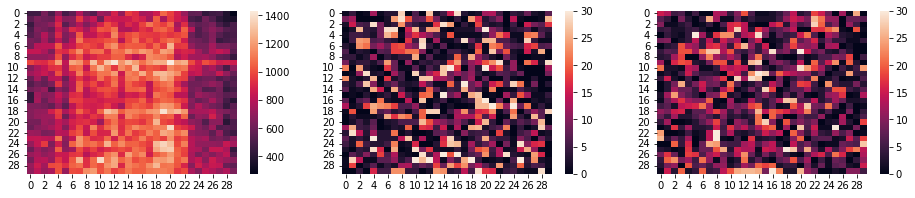

429.1025641025641


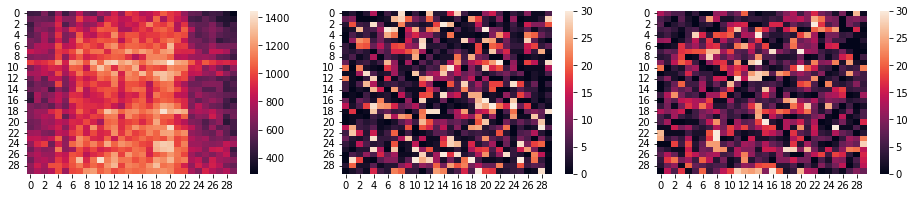

443.0


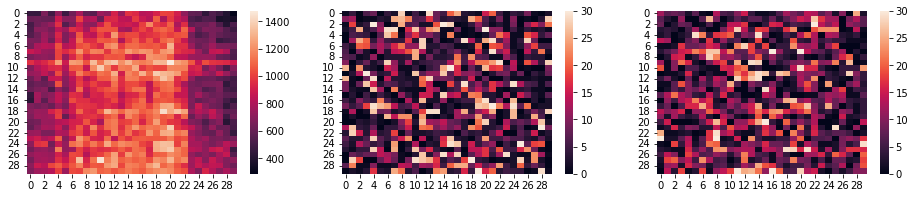

450.71794871794873


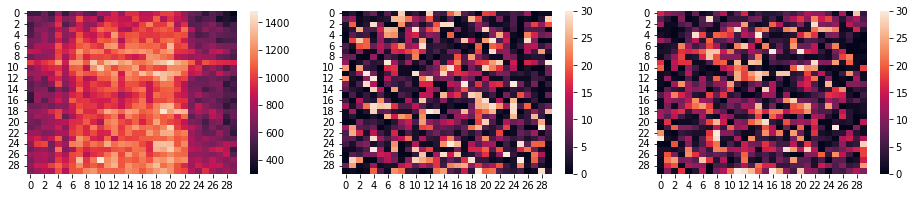

432.0153846153846


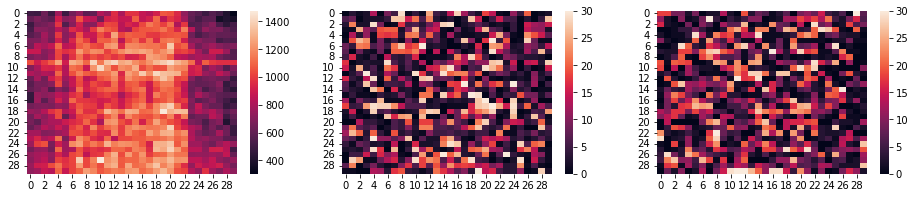

447.032967032967


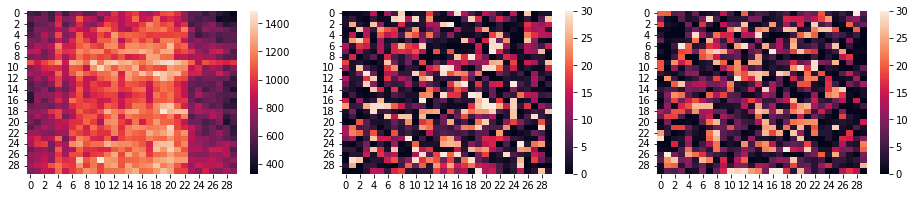

442.4241758241758


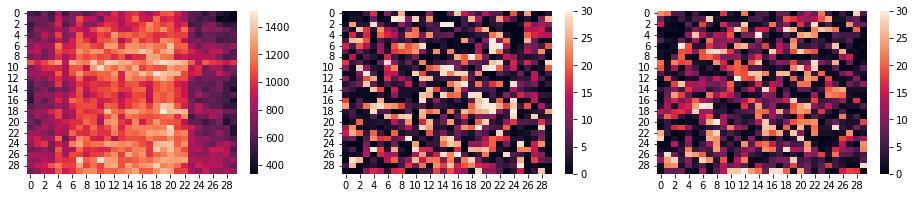

457.25


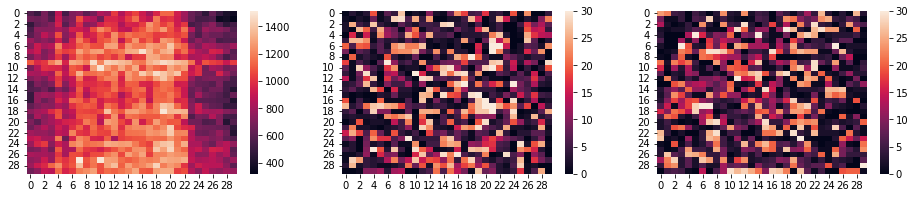

444.5833333333333


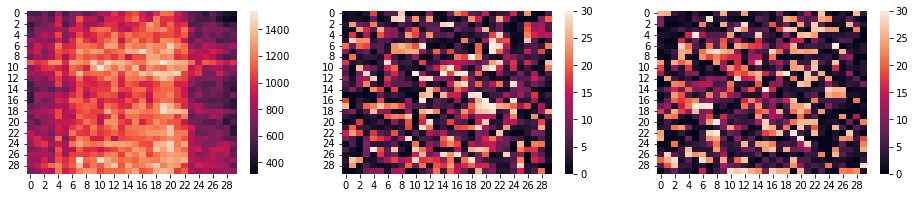

447.66666666666663


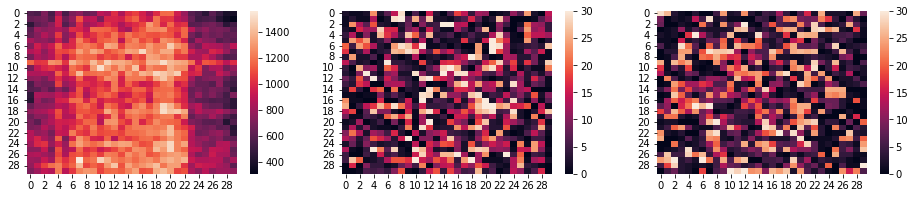

457.2857142857143


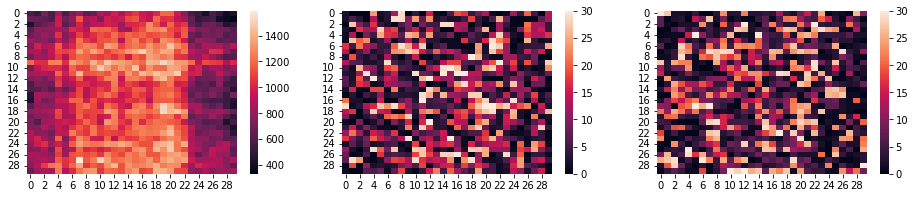

446.0


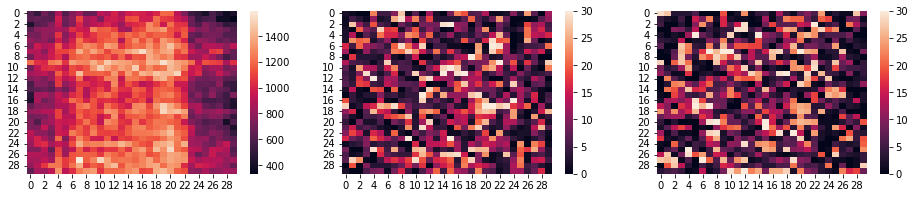

453.0


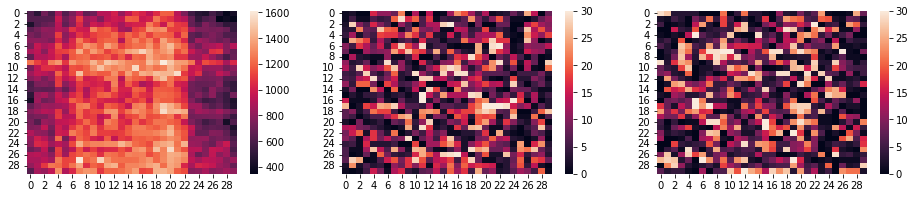

438.53846153846155


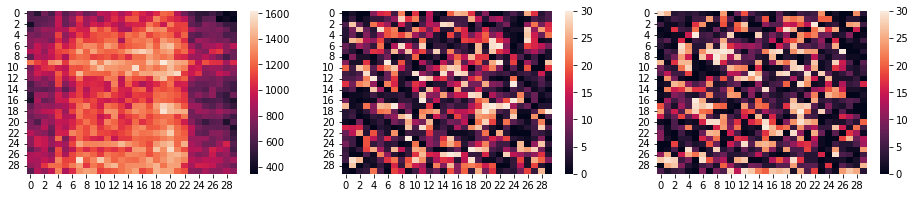

446.6666666666667


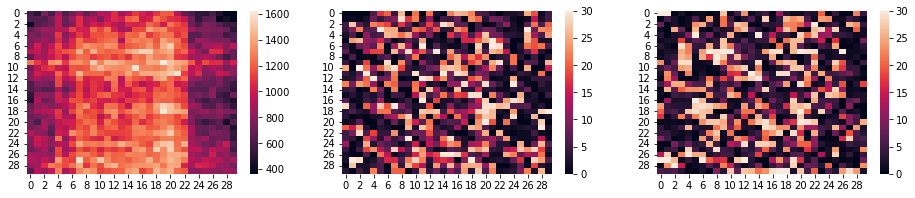

452.0


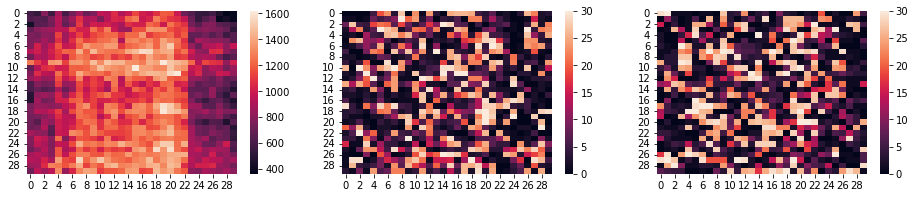

428.6583333333333


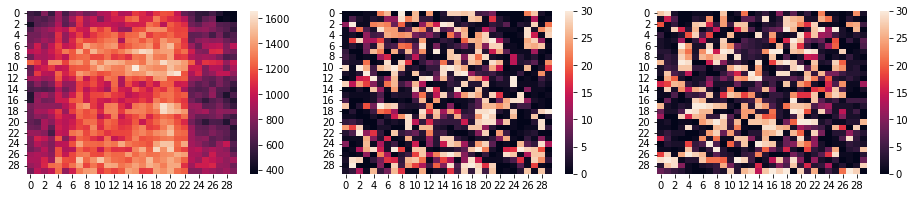

430.91666666666663


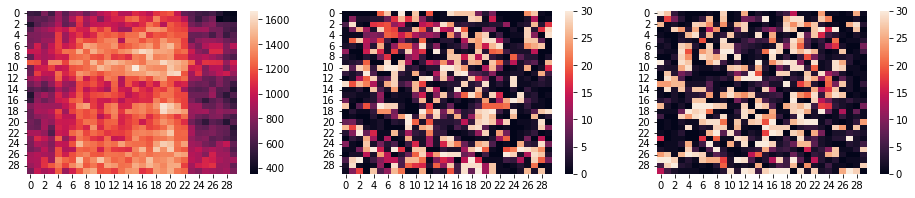

437.6


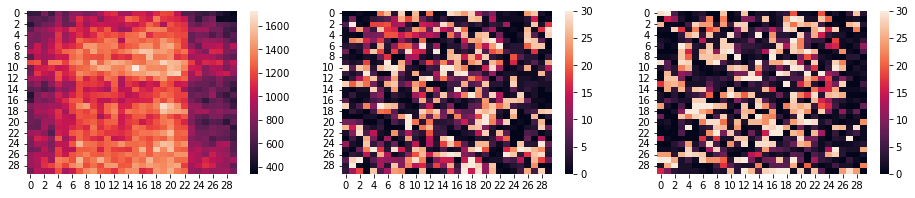

437.43809523809523


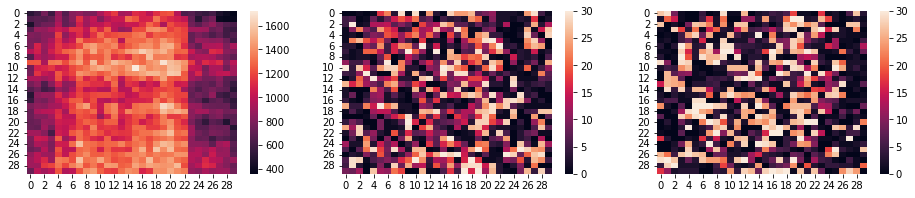

426.46153846153845


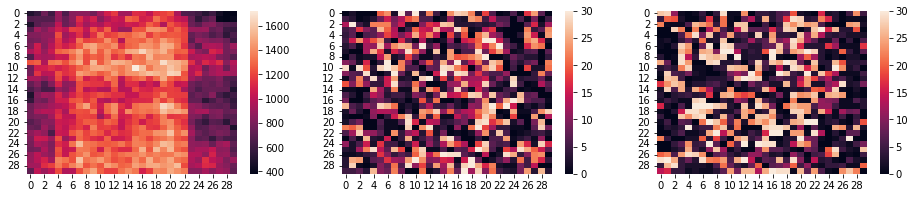

428.62745098039215


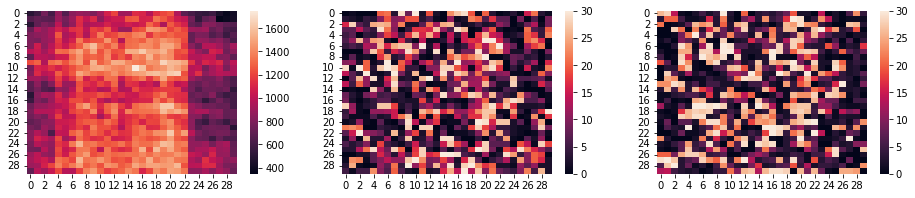

431.2828282828283


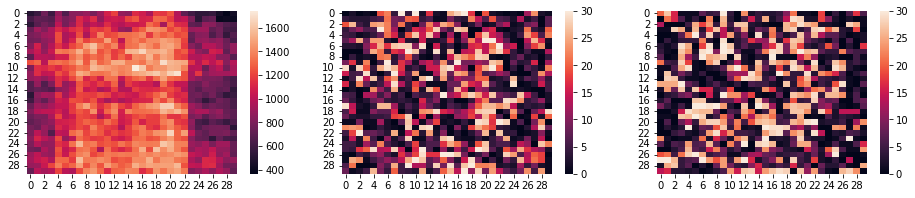

442.4166666666667


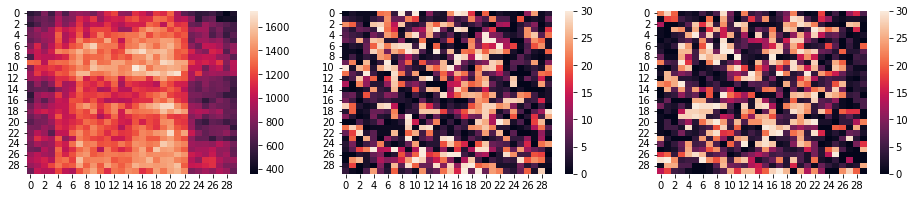

449.4


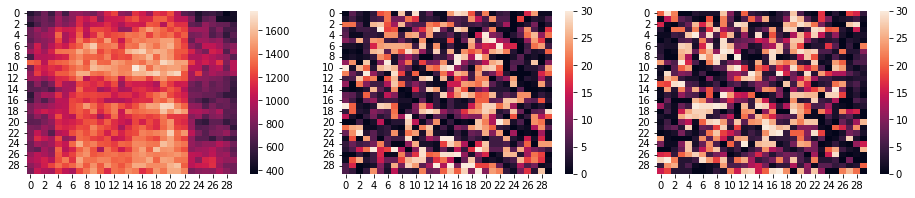

436.24107142857144


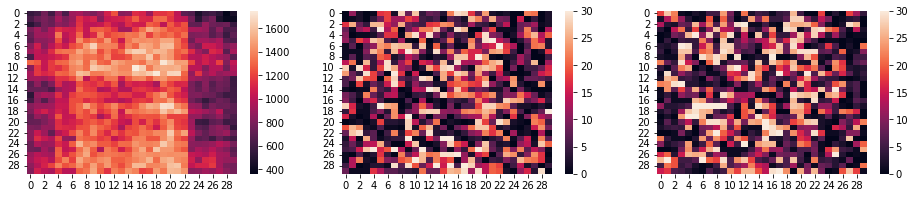

446.4553571428571


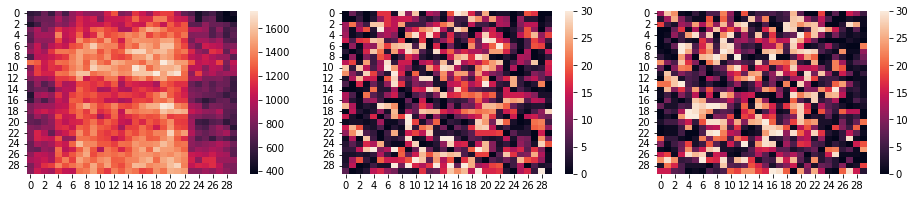

460.79166666666663


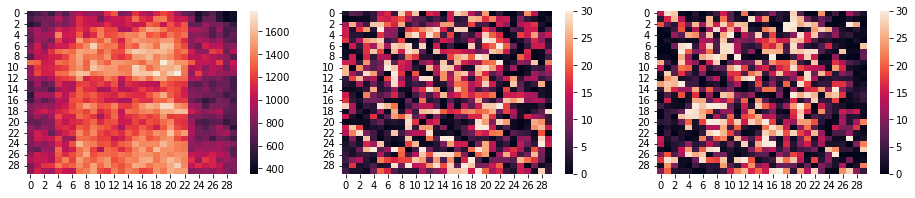

450.0


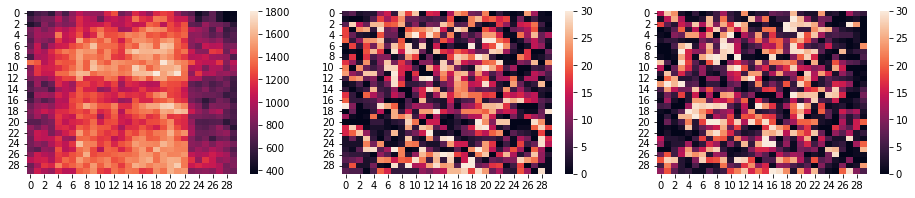

446.83333333333337


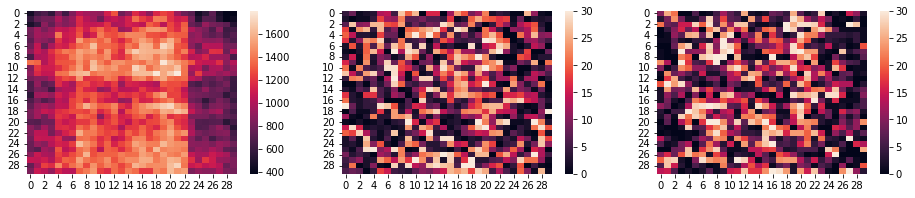

452.61538461538464


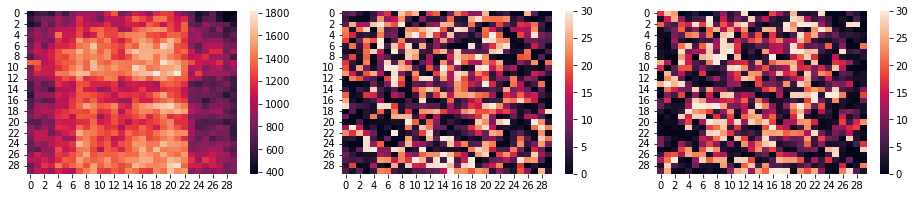

447.0


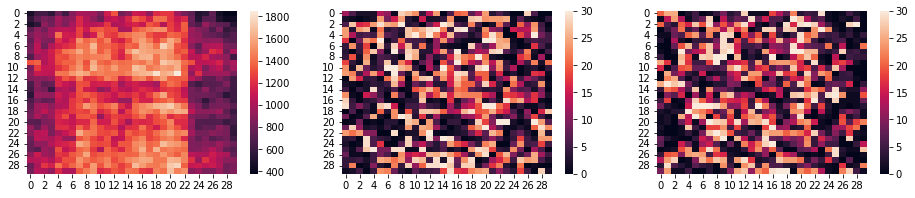

444.0


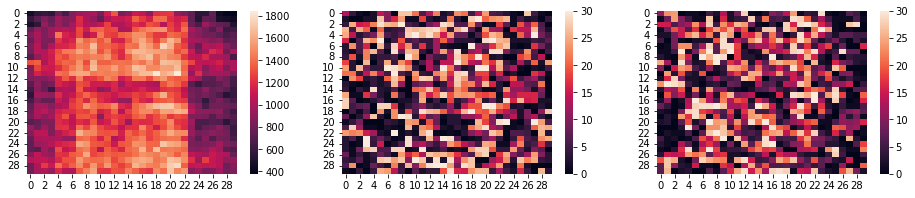

401.5833333333333


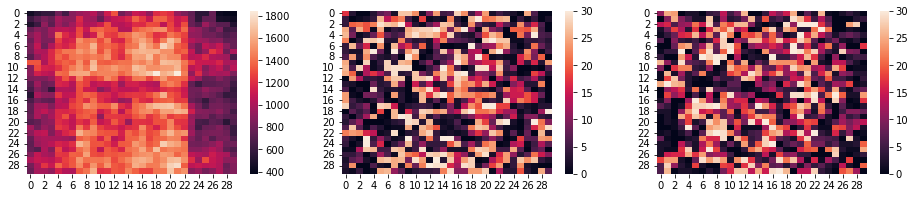

422.0


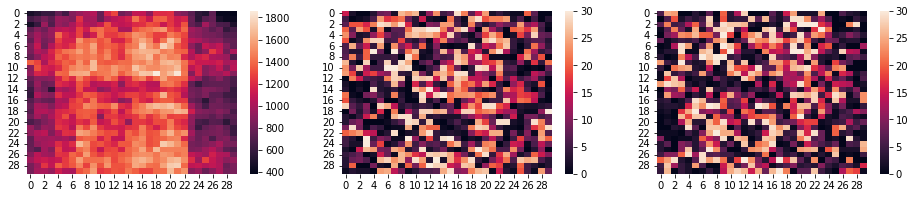

431.3642857142857


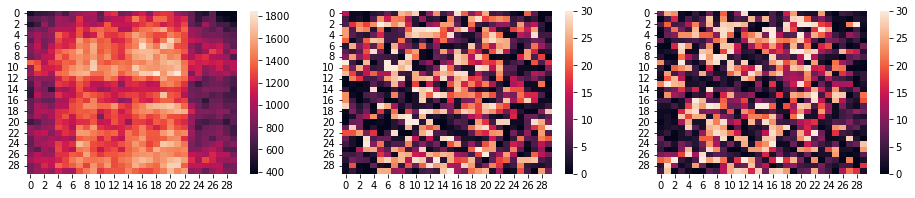

443.8888888888889


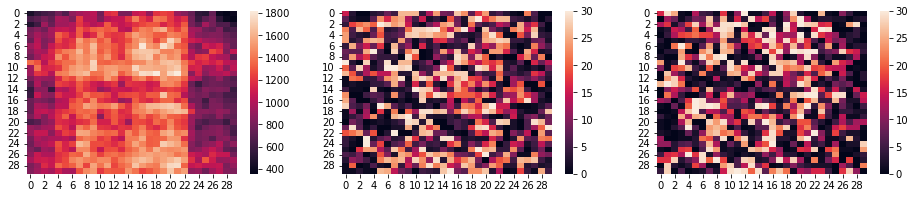

452.5


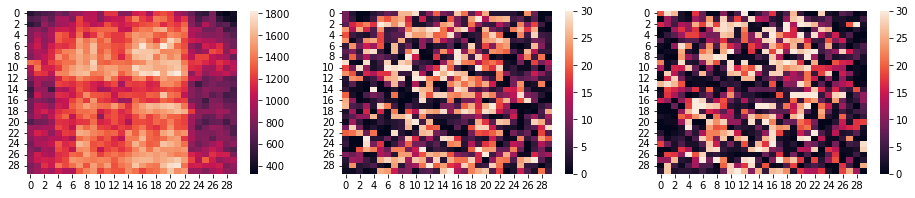

438.0


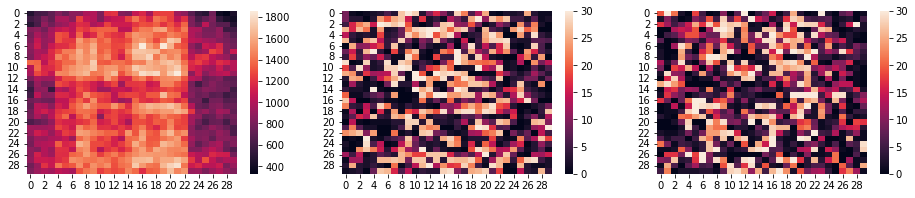

448.0


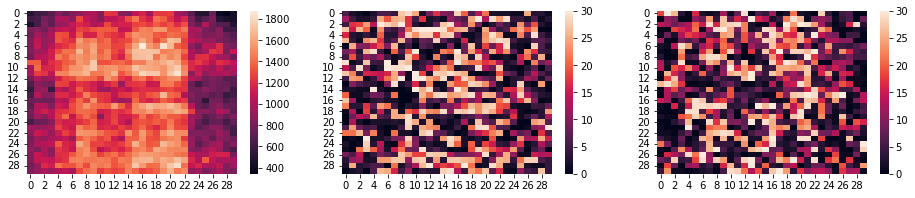

459.0


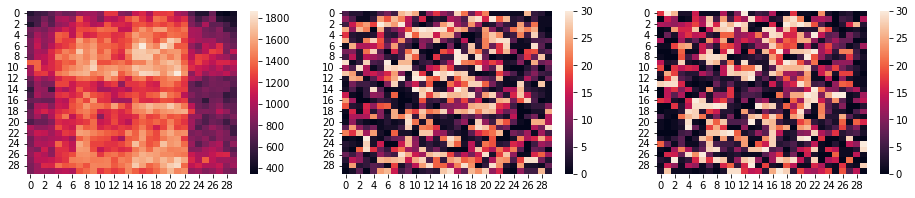

455.0


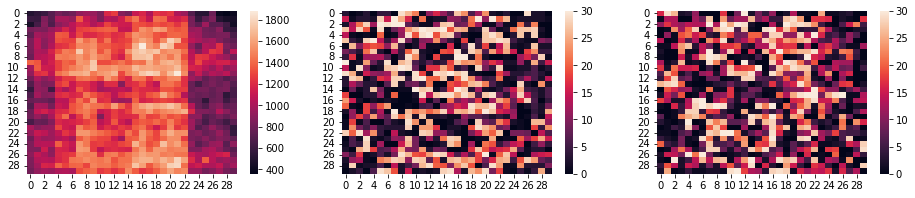

449.16883116883116


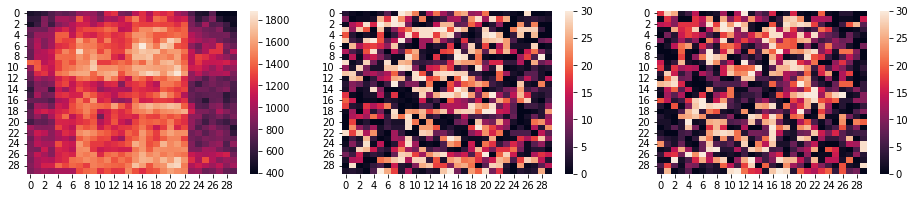

438.2857142857143


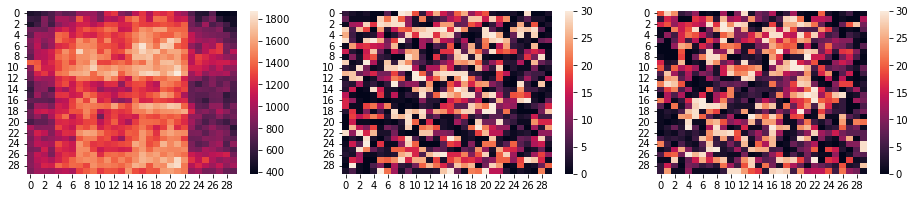

442.4545454545455


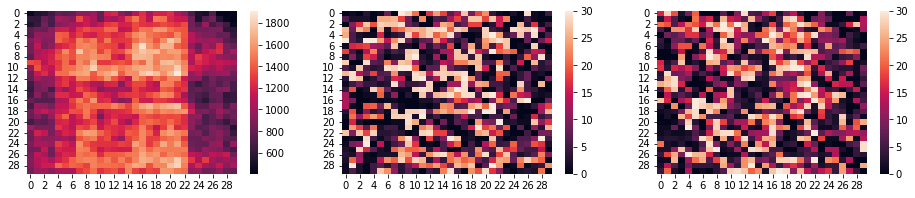

440.27922077922074


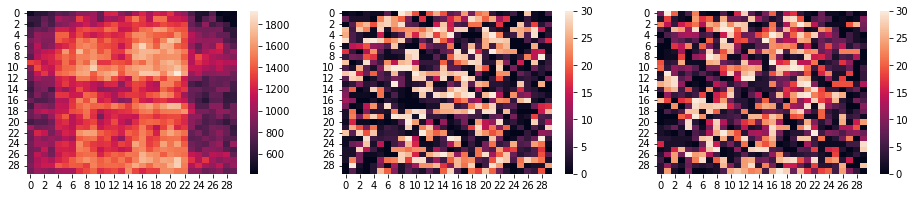

454.77777777777777


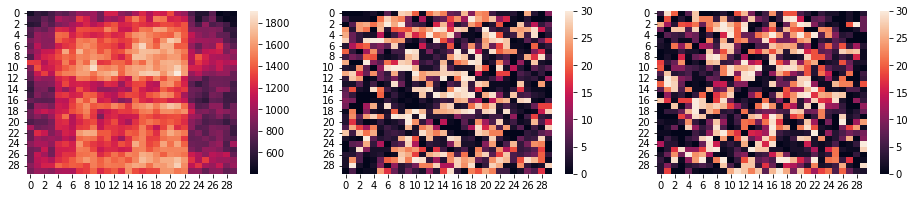

443.05357142857144


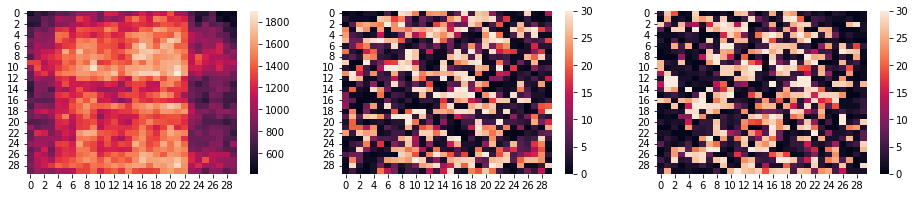

421.5882352941177


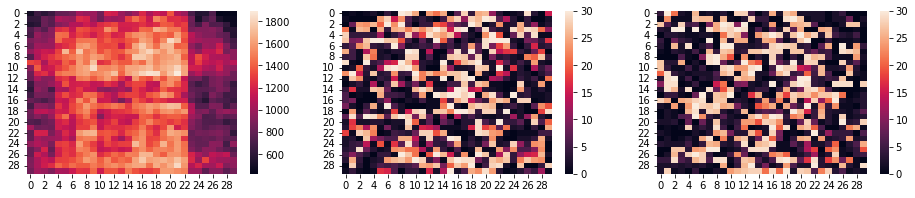

429.0952380952381


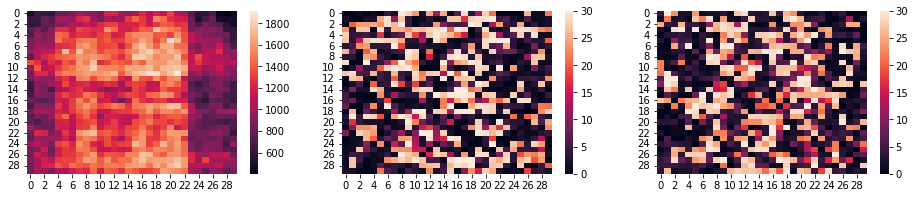

432.0


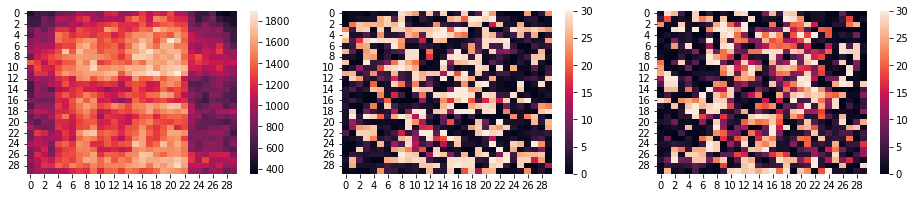

451.73333333333335


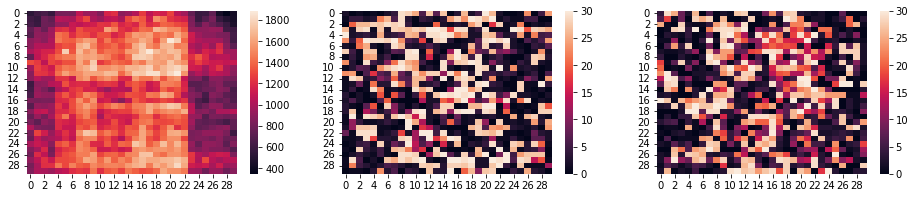

439.0


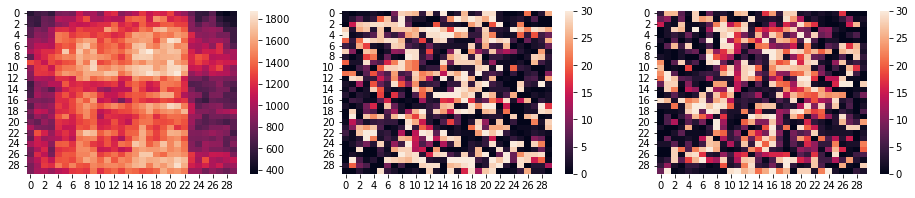

444.0


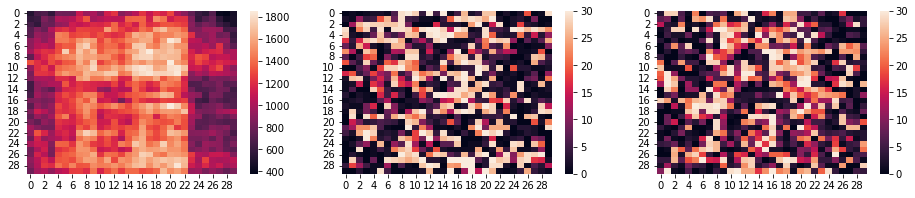

436.0


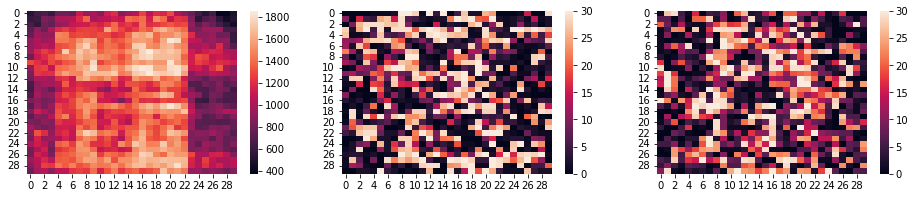

448.0


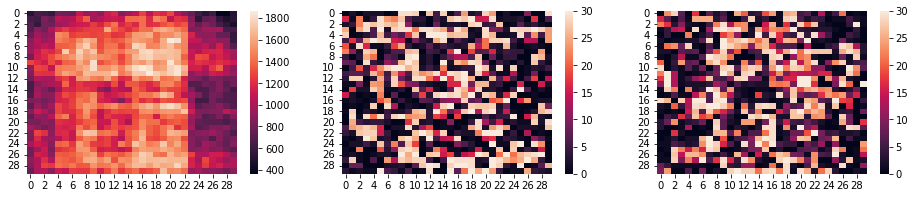

446.0


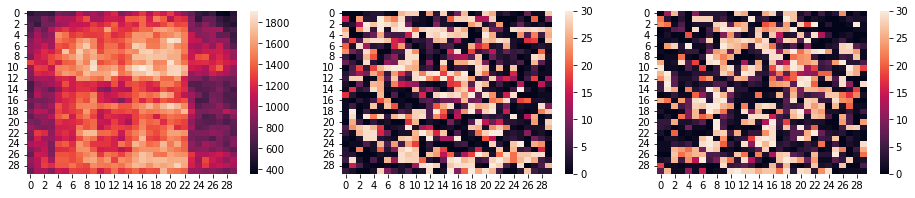

438.0


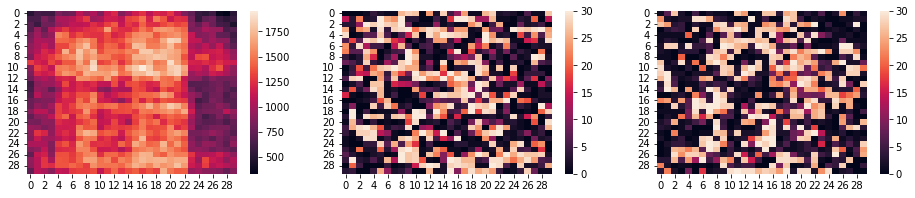

460.25


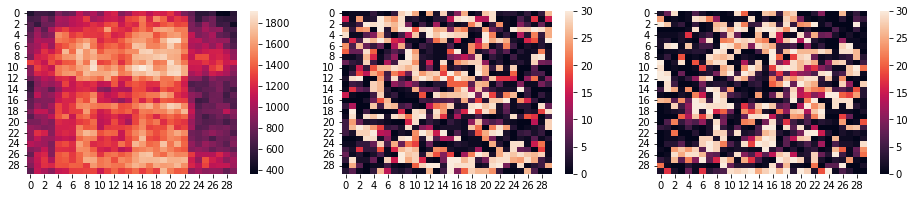

460.42857142857144


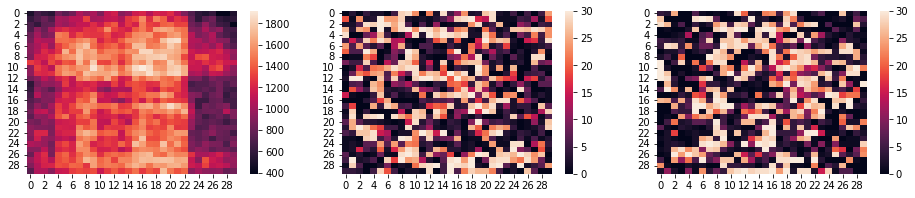

461.0


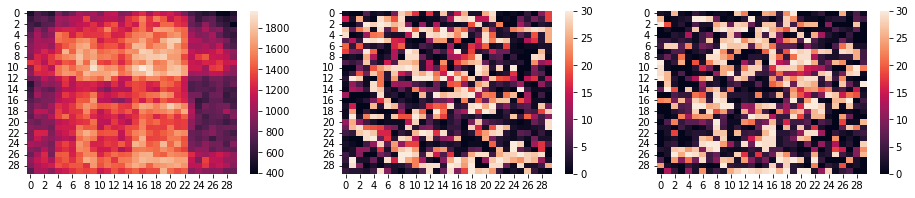

476.5833333333333


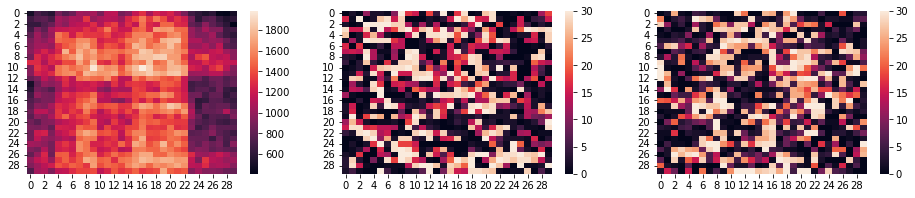

461.5333333333333


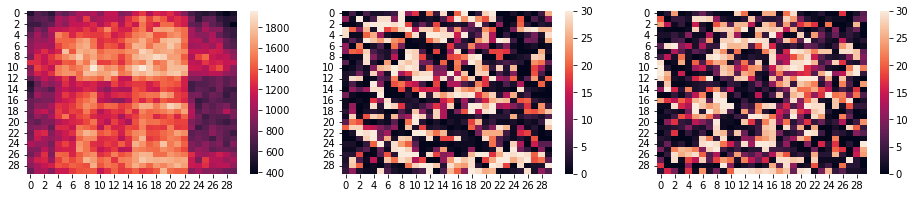

455.0


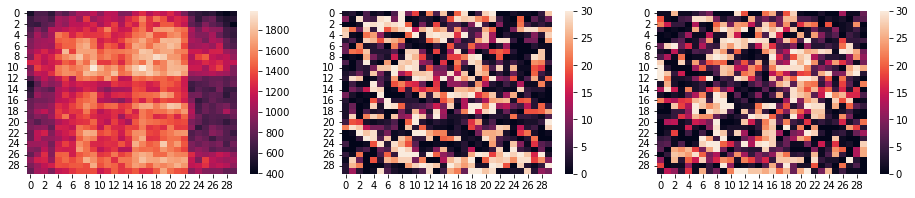

457.0


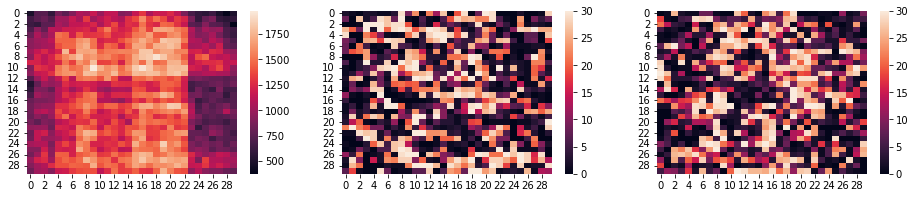

448.125


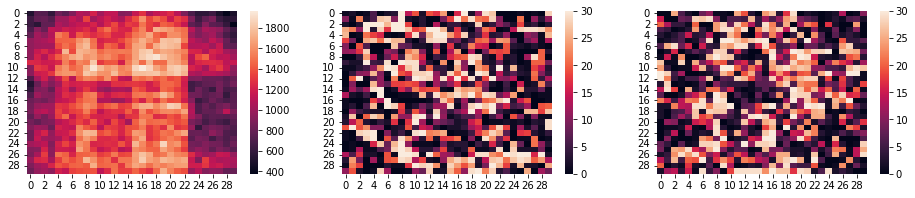

462.0


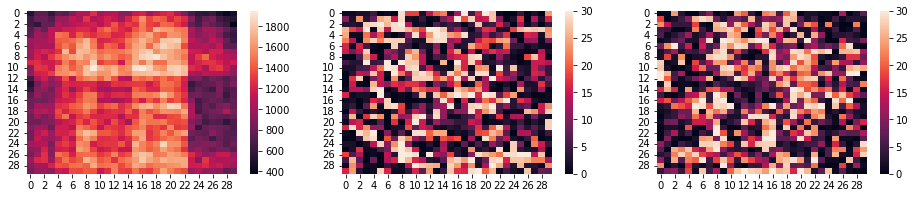

459.0


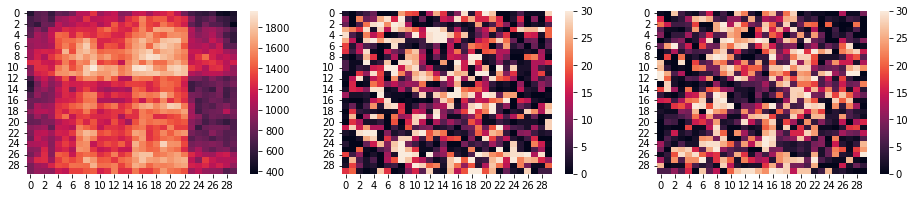

455.69444444444446


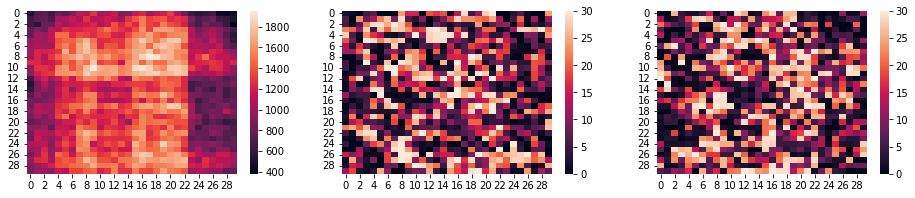

464.61538461538464


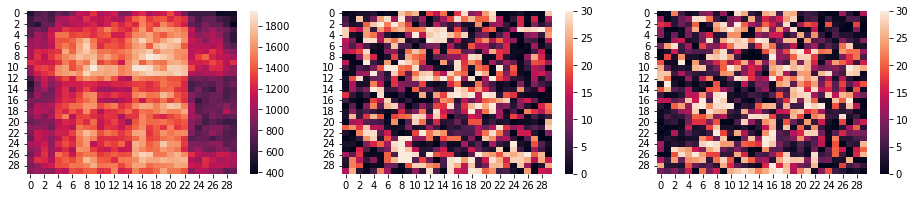

461.33333333333337


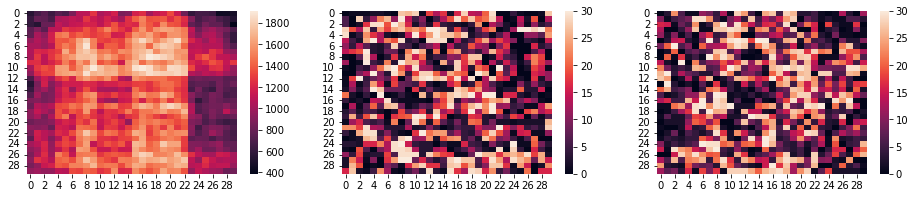

439.15277777777777


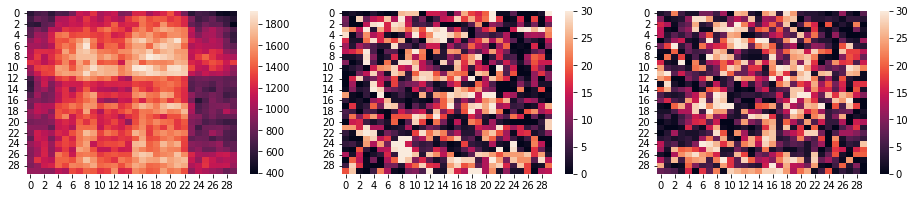

463.0


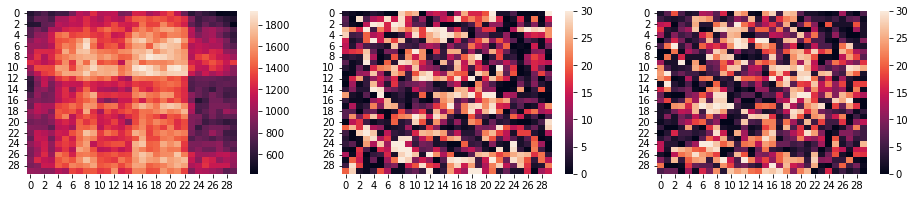

465.3605769230769


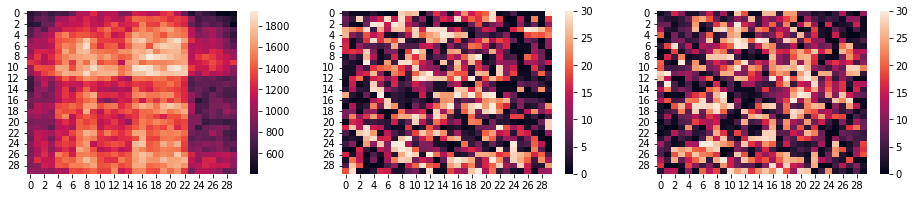

476.4375


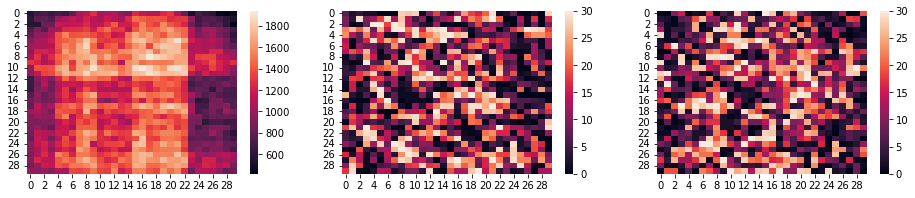

466.3809523809524


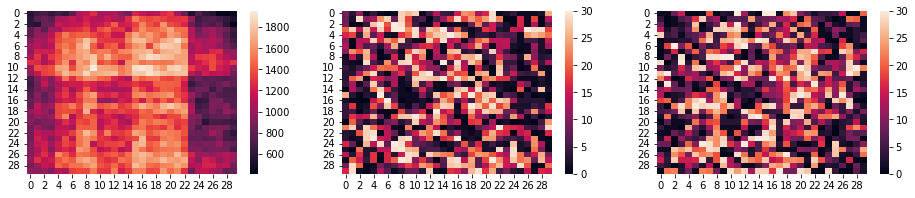

457.55555555555554


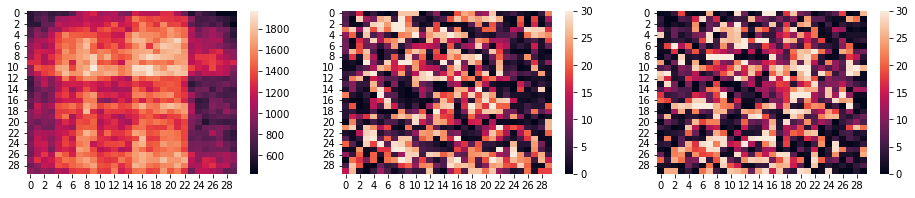

446.4375


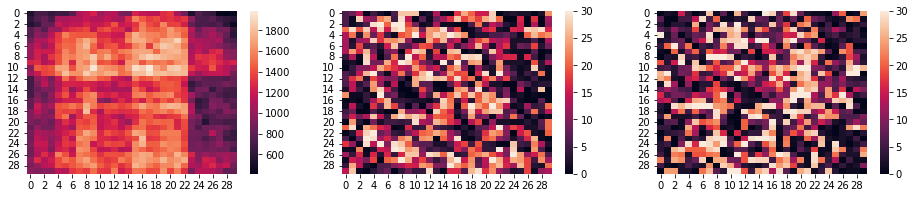

448.1282051282051


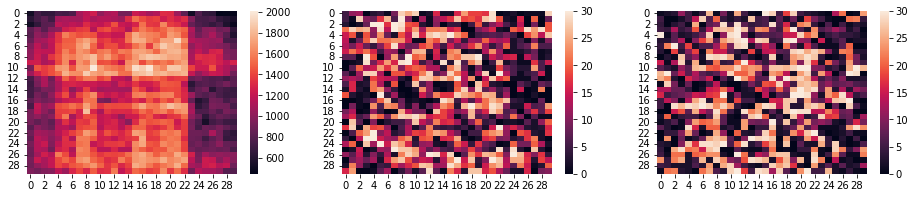

457.0


In [10]:
Agents = Run(100)
Agents = Run(100)